The purpose of this notebook is to explore positional encoding methods on transformer. It is currently based on the original my_transformer, instead of the 59_transformers. Besides, it tests the effect of Positional Encoding with original, normalized, and standardized data. It is expected that the choice between normalization and standardization might have an effect because positional encoding might have 0 to 1 values due to its prevelant use in NLP tasks.

In [1]:
import torch, math
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time

### Various preprocessing methods

In [2]:
theta_Tr = np.zeros(1)
theta_Te = np.zeros(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path_to_save_model = 'pos_encode_save_model/'

def preproceess_data(NUM_DATA, sanity_check = False):
    global theta_Tr, theta_Te
    # 1. Load the data from npz file
    if not sanity_check:
        data = np.load('10pendula.npz')
    else:
        data = np.load('10pendula_sanity_check.npz')
    for key, val in data.items():
        exec(key + '=val')
    og_theta = data['theta']
    # below prints the evolution of the position (angle) over time of the 2nd pendulum in the 121st sample
    # plt.plot(og_theta[:, 111, 3, 0])
    
    # 2. preproceses data to the dimension we want
    # now, there are NUM_DATA data entry (i.e. initial conditions), 
    # each has 60 timesteps, and each timestep is a vector of size 20 
    # each feature: [p0, v0, p1, v1, ... p19, v19]
    theta = np.transpose(og_theta, (1, 0, 2, 3)).reshape(50000, 60, 20)
    theta = theta[:NUM_DATA, :, :]
    N, _, _ = theta.shape
    cutoff = int(np.ceil(0.7 * N))
    theta_Tr = theta[:cutoff, :, :]
    theta_Te = theta[cutoff: , :, :]

def preproceess_data_standardize(NUM_DATA, sanity_check = False):
    global theta_Tr, theta_Te
    # 1. Load the data from npz file
    if not sanity_check:
        data = np.load('10pendula.npz')
    else:
        data = np.load('10pendula_sanity_check.npz')
    for key, val in data.items():
        exec(key + '=val')
    og_theta = data['theta']
    # below prints the evolution of the position (angle) over time of the 2nd pendulum in the 121st sample
    # plt.plot(og_theta[:, 111, 3, 0])
    
    # 2. preproceses data to the dimension we want
    # now, there are NUM_DATA data entry (i.e. initial conditions), 
    # each has 60 timesteps, and each timestep is a vector of size 20 
    # each feature: [p0, v0, p1, v1, ... p19, v19]
    theta = np.transpose(og_theta, (1, 0, 2, 3)).reshape(50000, 60, 20)
    theta = theta[:NUM_DATA, :, :]
    N, _, _ = theta.shape
    cutoff = int(np.ceil(0.7 * N))
    theta_Tr = theta[:cutoff, :, :]
    theta_Te = theta[cutoff: , :, :]
    
    # 3. standardize the data by viewing position and velocity as 2 features
    pos_tr = theta_Tr[:,:,::2]
    vel_tr = theta_Tr[:,:,1::2]
    
    mean_std_dict = {
        "mean_pos": np.mean(pos_tr),
        "std_pos": np.std(pos_tr),
        "mean_vel": np.mean(vel_tr),
        "std_vel": np.std(vel_tr)
    }
    
    theta_Tr[:,:,::2] = (theta_Tr[:,:,::2]  - mean_std_dict["mean_pos"]) / mean_std_dict["std_pos"] # position
    theta_Tr[:,:,1::2] = (theta_Tr[:,:,1::2]  - mean_std_dict["mean_vel"]) / mean_std_dict["std_vel"] # velocity
    
    theta_Te[:,:,::2] = (theta_Te[:,:,::2]  - mean_std_dict["mean_pos"]) / mean_std_dict["std_pos"] # position
    theta_Te[:,:,1::2] = (theta_Te[:,:,1::2]  - mean_std_dict["mean_vel"]) / mean_std_dict["std_vel"] # velocity
    
    return mean_std_dict

def preproceess_data_normalize(NUM_DATA, sanity_check = False):
    global theta_Tr, theta_Te
    # 1. Load the data from npz file
    if not sanity_check:
        data = np.load('10pendula.npz')
    else:
        data = np.load('10pendula_sanity_check.npz')
    for key, val in data.items():
        exec(key + '=val')
    og_theta = data['theta']
    # below prints the evolution of the position (angle) over time of the 2nd pendulum in the 121st sample
    # plt.plot(og_theta[:, 111, 3, 0])
    
    # 2. preproceses data to the dimension we want
    # now, there are NUM_DATA data entry (i.e. initial conditions), 
    # each has 60 timesteps, and each timestep is a vector of size 20 
    # each feature: [p0, v0, p1, v1, ... p19, v19]
    theta = np.transpose(og_theta, (1, 0, 2, 3)).reshape(50000, 60, 20)
    theta = theta[:NUM_DATA, :, :]
    N, _, _ = theta.shape
    cutoff = int(np.ceil(0.7 * N))
    theta_Tr = theta[:cutoff, :, :]
    theta_Te = theta[cutoff: , :, :]
    
    # 3. NORMALIZE the data by viewing position and velocity as 2 features
    pos_tr = theta_Tr[:,:,::2]
    vel_tr = theta_Tr[:,:,1::2]
    
    min_max_dict = {
        "min_pos": np.min(pos_tr),
        "max_pos": np.max(pos_tr),
        "min_vel": np.min(vel_tr),
        "max_vel": np.max(vel_tr)
    }
    
    theta_Tr[:,:,::2] = (theta_Tr[:,:,::2]  - min_max_dict["min_pos"]) / (min_max_dict["max_pos"] - min_max_dict["min_pos"]) # position
    theta_Tr[:,:,1::2] = (theta_Tr[:,:,1::2]  - min_max_dict["min_vel"]) / (min_max_dict["max_vel"] - min_max_dict["min_vel"]) # velocity
    
    theta_Te[:,:,::2] = (theta_Te[:,:,::2]  - min_max_dict["min_pos"]) / (min_max_dict["max_pos"] - min_max_dict["min_pos"]) # position
    theta_Te[:,:,1::2] = (theta_Te[:,:,1::2]  - min_max_dict["min_vel"]) / (min_max_dict["max_vel"] - min_max_dict["min_vel"]) # velocity
    
    return min_max_dict

### PositionalEncoding, the Model, and training

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, d_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)) / d_model) # 1000^(2i/d_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/d_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/d_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [4]:
class Transformer(nn.Module):
    # d_model : number of features
    def __init__(self,feature_size=20,num_layers=3,dropout=0):
        super(Transformer, self).__init__()
        self.positional_encoder = PositionalEncoding(d_model=feature_size, dropout=dropout, max_len=5000)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=5, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, device):
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        output = self.positional_encoder(src)
        output = self.transformer_encoder(output,mask)
        output = self.decoder(output)
        return output

In [11]:
def train_transformer_teacher_forcing(EPOCH = 200):
    model = Transformer().double().to(device)
    model.train()  # turn on train mode
    
    model = Transformer().double().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.MSELoss()
    best_model = ""
    min_train_loss = float('inf')
    
    for epoch in range(EPOCH + 1):
        train_loss = 0
        for i in range(theta_Tr.shape[0]):
            # iterate through each training example
            cur_theta = theta_Tr[i] # check dim later; not sure about batch
            optimizer.zero_grad()
            
            src = cur_theta[:-1,:] # input is the vector except for the last time step's
            src = torch.from_numpy(np.expand_dims(src, axis=1)).double().to(device) # torch.Size([59, 1, 20]) as 1 is batchsize
            target = cur_theta[1:,:] # this is the ground truth output, shift by one according to Medium blog post
            target = torch.from_numpy(np.expand_dims(target, axis=1)).double().to(device) # torch.Size([59, 1, 20])
            
            prediction = model(src, device)
            loss = criterion(prediction, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item()
            
        if train_loss < min_train_loss:
            torch.save(model.state_dict(), path_to_save_model + f"best_train.pth")
            torch.save(optimizer.state_dict(), path_to_save_model + f"optimizer.pth")
            min_train_loss = train_loss
            
        if epoch % (np.ceil(EPOCH / 10)) == 0:
            print(f"Epoch: {epoch}, Average training loss: {train_loss / theta_Tr.shape[0]}")

### 2 visualization methods

In [18]:
def visualize_test(loss_array, average_testing_loss, want_worst = False, want_avg = False):
    """
    If want worst, will plot the test with the highest loss
    If want avg, will plot the test with the loss closest to the average
    """
    assert (want_worst + want_avg) == 1 # can only visualize one
    
    # 1. first locate the id that we want to visualize
    viz_id = -1
    if want_worst:
        viz_id = np.argmax(loss_array)
    elif want_avg:
        viz_id = np.argmin(np.abs(loss_array - average_testing_loss))
        
    # 2. rerun model for this test
    model = Transformer().double().to(device)
    # model.load_state_dict(torch.load(path_to_save_model+"best_train.pth"))
    model.load_state_dict(torch.load(path_to_save_model+"best_train.pth"))
    criterion = torch.nn.MSELoss()

    all_predictions = []
    cur_loss = 0
    
    with torch.no_grad():
        cur_theta = theta_Te[viz_id]
        src = cur_theta[0,:] # t0
        src = torch.from_numpy(np.expand_dims(src, axis=[0,1])).double().to(device) # torch.Size([1, 1, 20]) as 1 is batchsize
        target = cur_theta[1:,:] # shift by one according to Medium # t1 to 59
        target = torch.from_numpy(np.expand_dims(target, axis=1)).double().to(device)
        next_input_model = src
        
        for j in range(59): # iterate through the entire forecast window
            prediction = model(next_input_model, device) # torch.Size([j, 1, 20])
            if all_predictions == []:
                all_predictions = prediction # 1, 1, 20
            else:
                all_predictions = torch.cat((all_predictions, prediction[-1,:,:].unsqueeze(0)))
            next_input_model = all_predictions
            
        cur_loss = criterion(all_predictions, target).item()
        
    print("Average testing loss is: " + str(average_testing_loss))
    print("Visualizing test with loss: " + str(cur_loss))
    target = theta_Te[viz_id, 1:]
    prediction = torch.squeeze(all_predictions).cpu()
    
    # 3. first plot position
    fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 200, sharex=True, sharey=True)
    for i_loop in range(10):
        i = i_loop * 2 # since we only want the position features
        plt.sca(axs.flatten()[i_loop])
        plt.plot(target[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'ground truth')
        plt.plot(prediction[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'NN prediction')
        plt.xlabel('Timestep')
        plt.ylabel('Position')
        plt.title(f'Pendulum {i_loop}')
        plt.grid()
    fig.suptitle("Position Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 4. then plot velocity
    fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 100, sharex=True, sharey=True)
    for i_loop in range(10):
        i = i_loop * 2 + 1 # since we only want the velocity features
        plt.sca(axs.flatten()[i_loop])
        plt.plot(target[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'ground truth')
        plt.plot(prediction[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'NN prediction')
        plt.xlabel('Timestep')
        plt.ylabel('Velocity')
        plt.title(f'Pendulum {i_loop}')
        plt.grid()
    fig.suptitle("Velocity Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
def visualize_worst_test(worst_dict):
    # 1. first plot position
    target_D = theta_Te[worst_dict["id"], 1:] # 59 x 20, target for each timestamp, each feature
    pred_D = torch.squeeze(worst_dict["pred"]) # 59 x 20, a prediction for each timestamp, each feature
    fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 200, sharex=True, sharey=True)
    for i_loop in range(10):
        i = i_loop * 2 # since we only want the position features
        plt.sca(axs.flatten()[i_loop])
        plt.plot(target_D[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'ground truth')
        plt.plot(pred_D[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'NN prediction')
        plt.xlabel('Timestep')
        plt.ylabel('Position')
        plt.title(f'Pendulum {i_loop}')
        plt.grid()
    fig.suptitle("Position Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 2. then plot velocity
    target_D = theta_Te[worst_dict["id"], 1:] # 59 x 20, target for each timestamp, each feature
    pred_D = torch.squeeze(worst_dict["pred"]) # 59 x 20, a prediction for each timestamp, each feature
    fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 100, sharex=True, sharey=True)
    for i_loop in range(10):
        i = i_loop * 2 + 1 # since we only want the velocity features
        plt.sca(axs.flatten()[i_loop])
        plt.plot(target_D[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'ground truth')
        plt.plot(pred_D[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'NN prediction')
        plt.xlabel('Timestep')
        plt.ylabel('Velocity')
        plt.title(f'Pendulum {i_loop}')
        plt.grid()
    fig.suptitle("Velocity Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 2 different inferences

In [8]:
def inference_cheat():
    """
    We call it cheat because the Transformer is not supposed to know any other input
    except for the initial condition (i.e. the t0 state)
    """ 
    model = Transformer().double().to(device)
    model.load_state_dict(torch.load(path_to_save_model+"best_train.pth"))
    criterion = torch.nn.MSELoss()
    
    total_loss = 0
    
    # loss_dict records the loss for each test, for visualization purpose 
    loss_dict = np.zeros(theta_Te.shape[0])
    
    with torch.no_grad():
        for i in range(theta_Te.shape[0]):
            cur_theta = theta_Te[i]
            src = cur_theta[:-1,:] # t0 to 58 # THE CHEATING PART
            src = torch.from_numpy(np.expand_dims(src, axis=1)).double() # torch.Size([59, 1, 20]) as 1 is batchsize
            target = cur_theta[1:,:] # shift by one according to Medium # t1 to 59
            target = torch.from_numpy(np.expand_dims(target, axis=1)).double()
            
            prediction = model(src, device) # t1 to 59
            cur_loss = criterion(prediction, target).item()
            total_loss += cur_loss
            
            loss_dict[i] = cur_loss
             
    return total_loss / theta_Te.shape[0], loss_dict

In [13]:
def inference_one_input():
    """
    As opposed to the cheating version of inference, the Transformer will only know about the t0 for input;
    then each time the transformer predicts the next timestamp, this output is recycled to be the input
    for the next timestamp's input.
    """ 
    model = Transformer().double().to(device)
    model.load_state_dict(torch.load(path_to_save_model+"best_train.pth"))
    criterion = torch.nn.MSELoss()
    
    total_loss = 0
    loss_array = np.zeros(theta_Te.shape[0])
    
    with torch.no_grad():
        for i in range(theta_Te.shape[0]):
            cur_theta = theta_Te[i]
            src = cur_theta[0,:] # t0
            src = torch.from_numpy(np.expand_dims(src, axis=[0,1])).double().to(device) # torch.Size([1, 1, 20]) as 1 is batchsize
            
            target = cur_theta[1:,:] # shift by one according to Medium # t1 to 59
            target = torch.from_numpy(np.expand_dims(target, axis=1)).double().to(device)
            
            all_predictions = []
            next_input_model = src
            
            for j in range(59): # iterate through the entire forecast window
                prediction = model(next_input_model, device) # torch.Size([j, 1, 20])
                
                if all_predictions == []:
                    all_predictions = prediction # 1, 1, 20
                else:
                    all_predictions = torch.cat((all_predictions, prediction[-1,:,:].unsqueeze(0)))
                    
                next_input_model = all_predictions
            
            cur_loss = criterion(all_predictions, target).item()
            total_loss += cur_loss
            loss_array[i] = cur_loss
             
    return total_loss / theta_Te.shape[0], loss_array

### PE with og data

In [14]:
preproceess_data(NUM_DATA = 200, sanity_check = False)
best_model = train_transformer_teacher_forcing(EPOCH = 300)

Epoch: 0, Average training loss: 20.41409900681132
Epoch: 30, Average training loss: 0.7747226961896795
Epoch: 60, Average training loss: 0.6157268581125679
Epoch: 90, Average training loss: 0.3801420155427931
Epoch: 120, Average training loss: 0.31320536175911395
Epoch: 150, Average training loss: 0.2551994760455255
Epoch: 180, Average training loss: 0.24931428052288304
Epoch: 210, Average training loss: 0.2407718492510243
Epoch: 240, Average training loss: 0.2027516762985219
Epoch: 270, Average training loss: 0.19309472776994752
Epoch: 300, Average training loss: 0.15058721809959666


average loss is: 0.5499829189767248
Visualizing test with loss: 0.5465174772916961


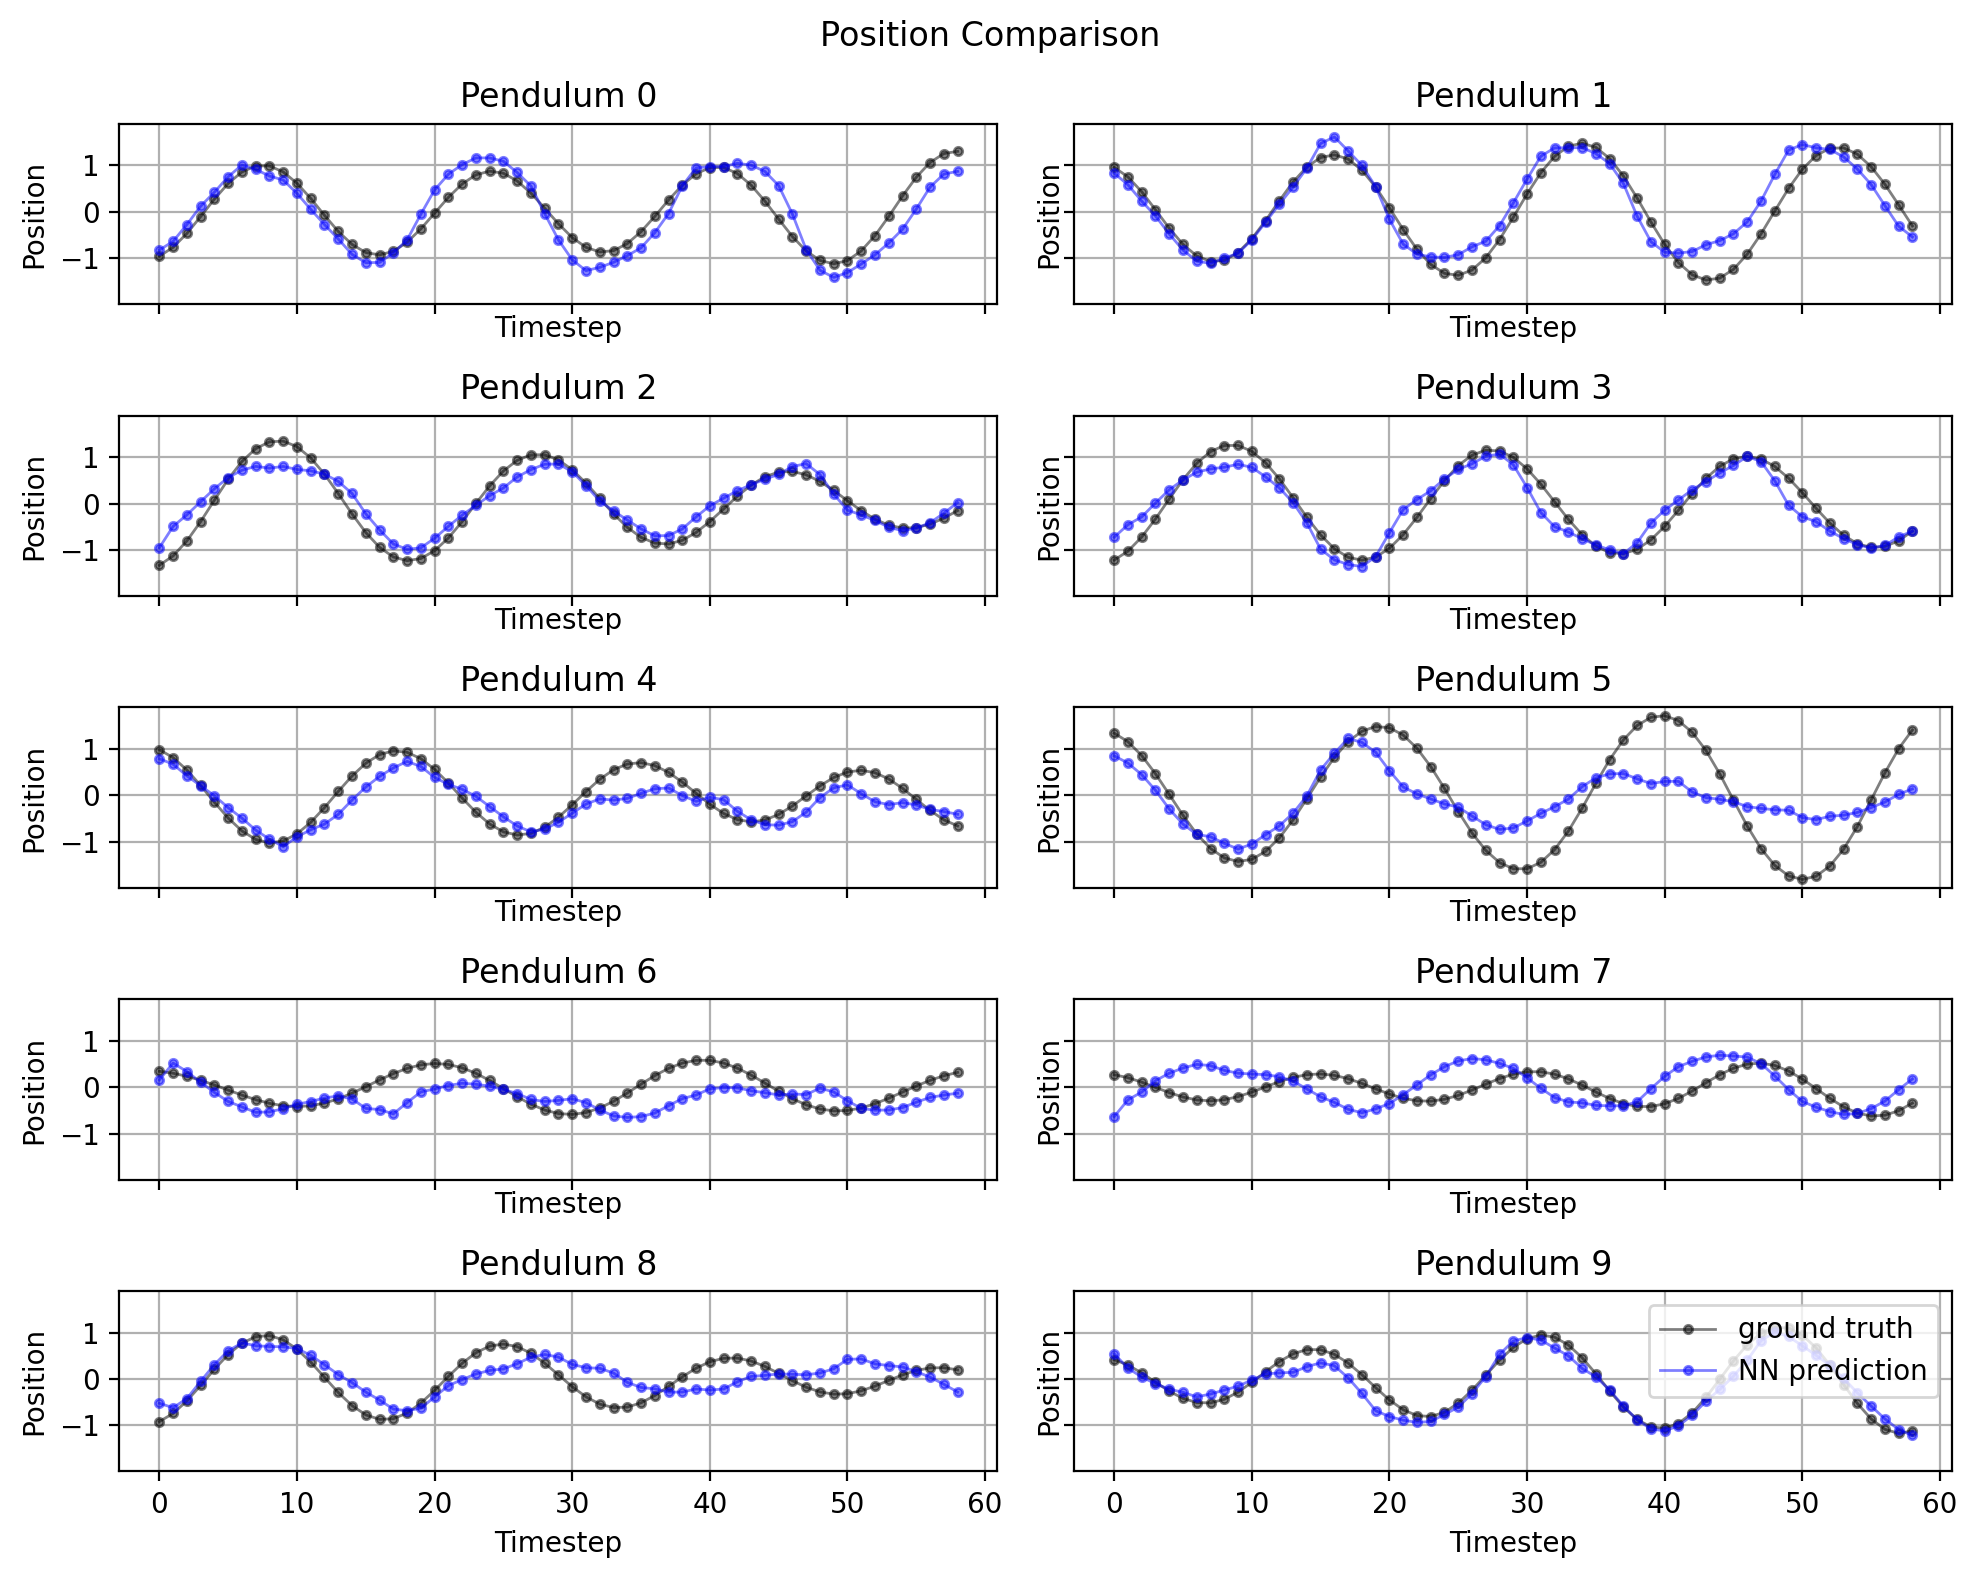

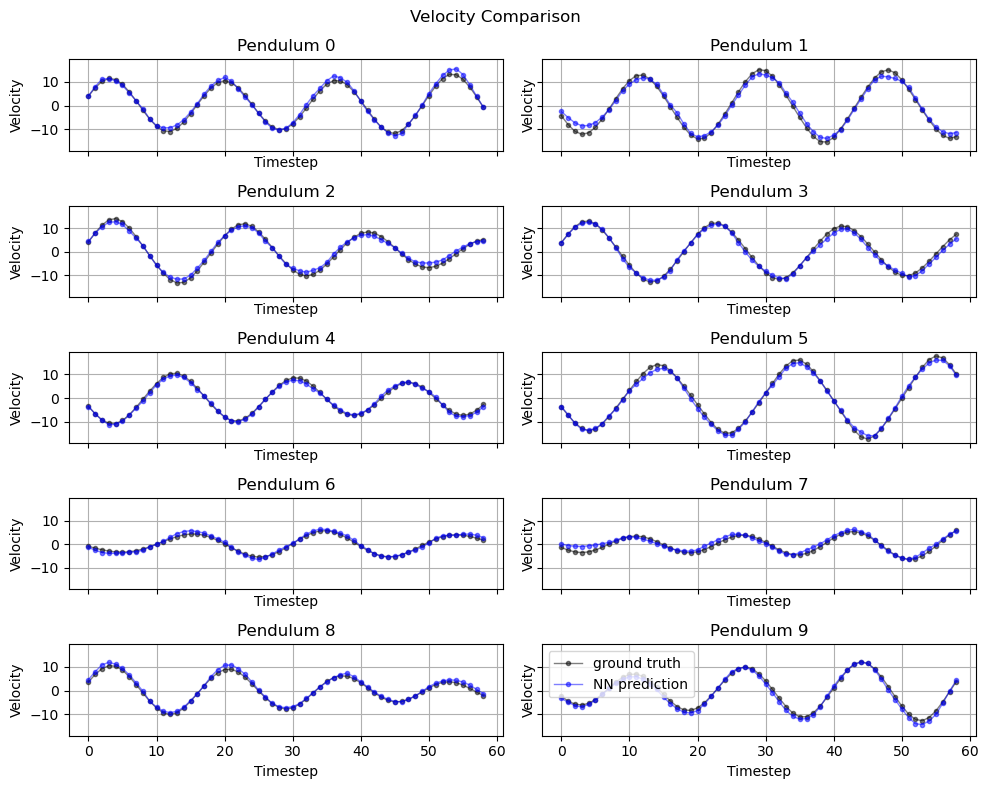

In [15]:
average_testing_loss, loss_list = inference_cheat()

print("average loss is: " + str(average_testing_loss))
visualize_test(loss_list, average_testing_loss, want_worst = False, want_avg = True)

39.52901634122288
73.30784899802542


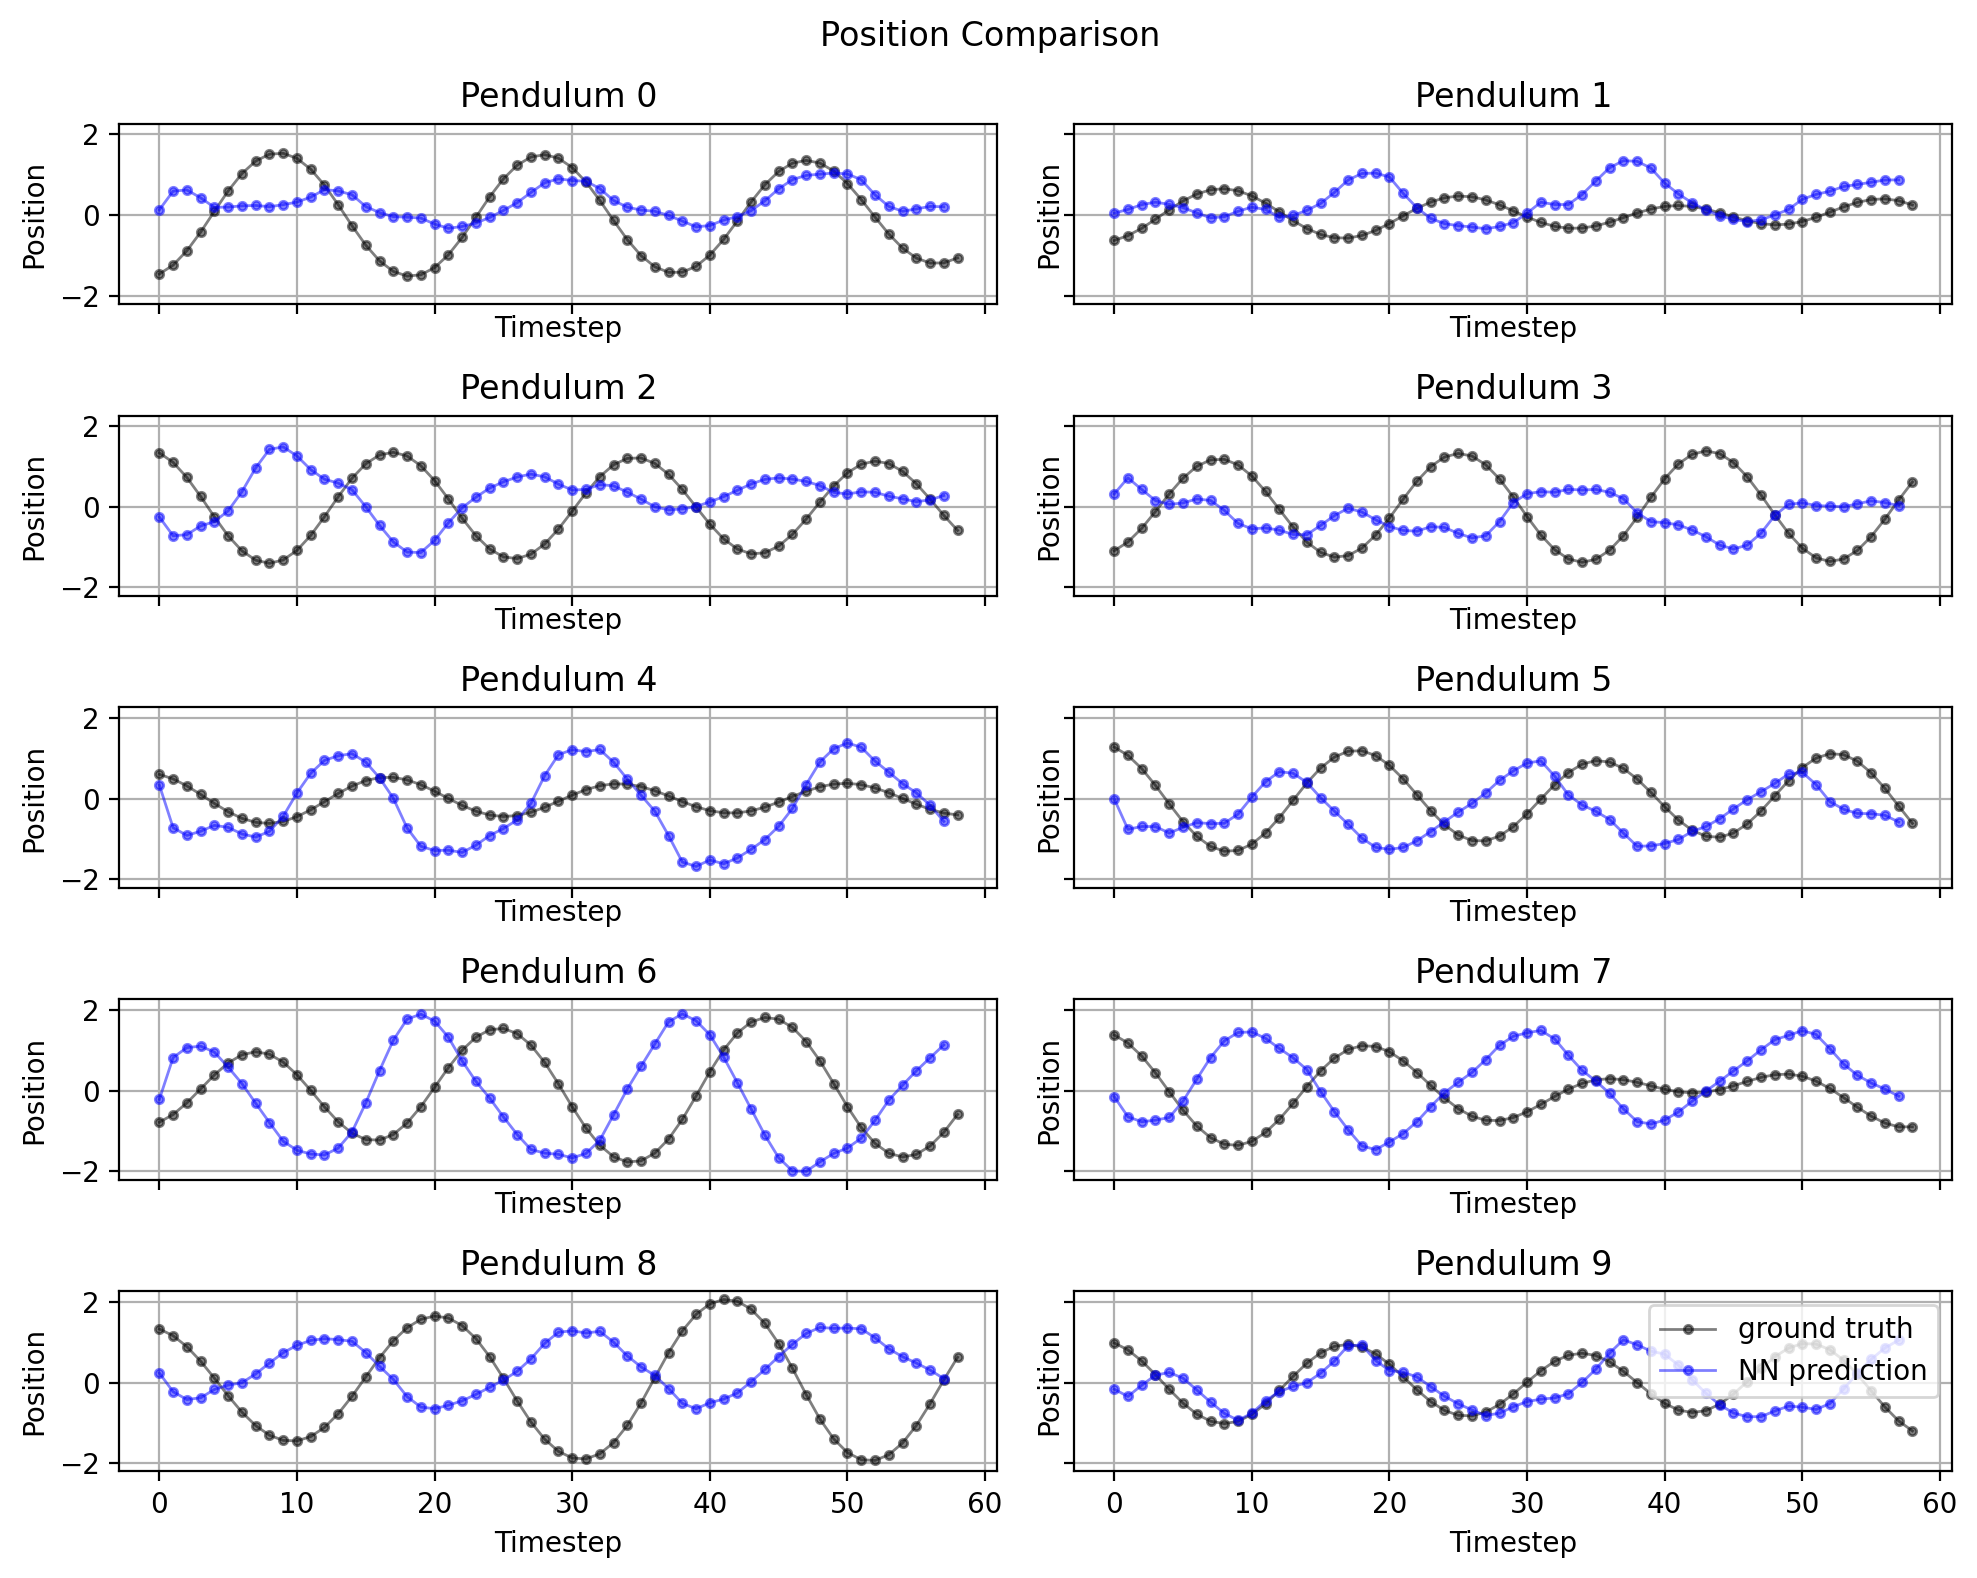

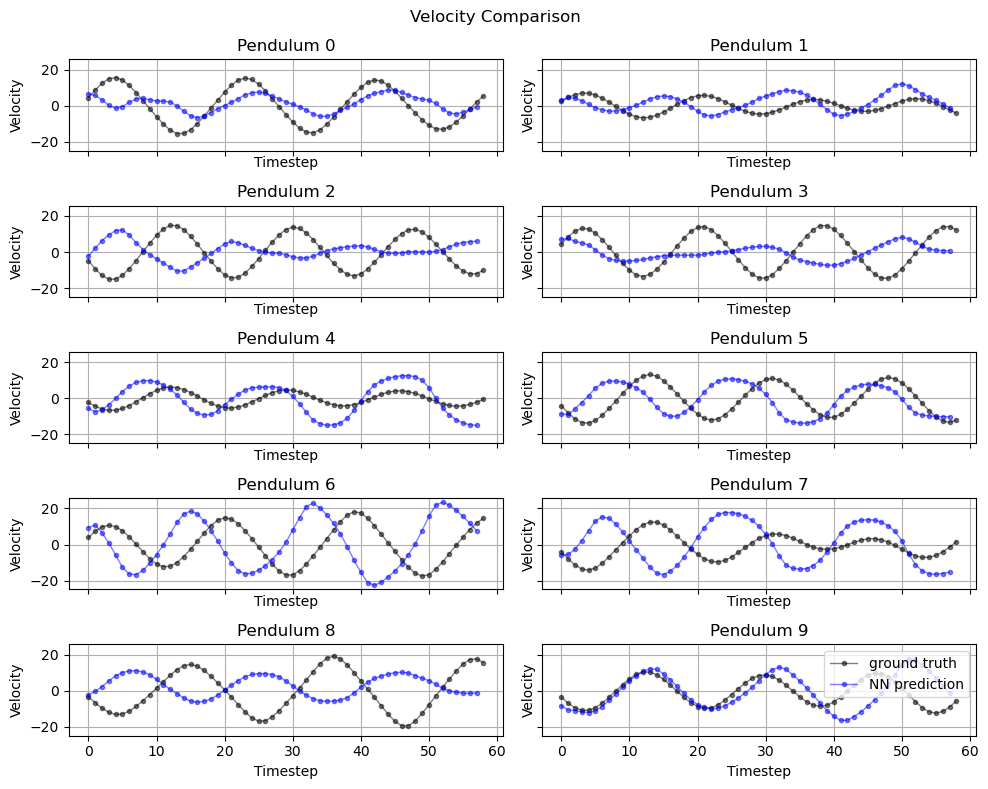

In [16]:
average_testing_loss, worst_dict = inference_one_input()
print(average_testing_loss)
print(worst_dict['loss'])
visualize_worst_test(worst_dict)

### PE with Normalized data

In [24]:
min_max_dict = preproceess_data_normalize(NUM_DATA = 200, sanity_check = False)
best_model = train_transformer_teacher_forcing(EPOCH = 300)

Epoch: 0, Average training loss: 0.03300362665839201
Epoch: 30, Average training loss: 0.003332292300451161
Epoch: 60, Average training loss: 0.0022231667793419156
Epoch: 90, Average training loss: 0.0019804889180378015
Epoch: 120, Average training loss: 0.001883421781353609
Epoch: 150, Average training loss: 0.0017341877346364666
Epoch: 180, Average training loss: 0.0016187360314913939
Epoch: 210, Average training loss: 0.001455541940463938
Epoch: 240, Average training loss: 0.0014427422626603133
Epoch: 270, Average training loss: 0.001346692253141933
Epoch: 300, Average training loss: 0.001407353304457287


average loss is: 0.005399870243909325
Visualizing test with loss: 0.0054323867495328065


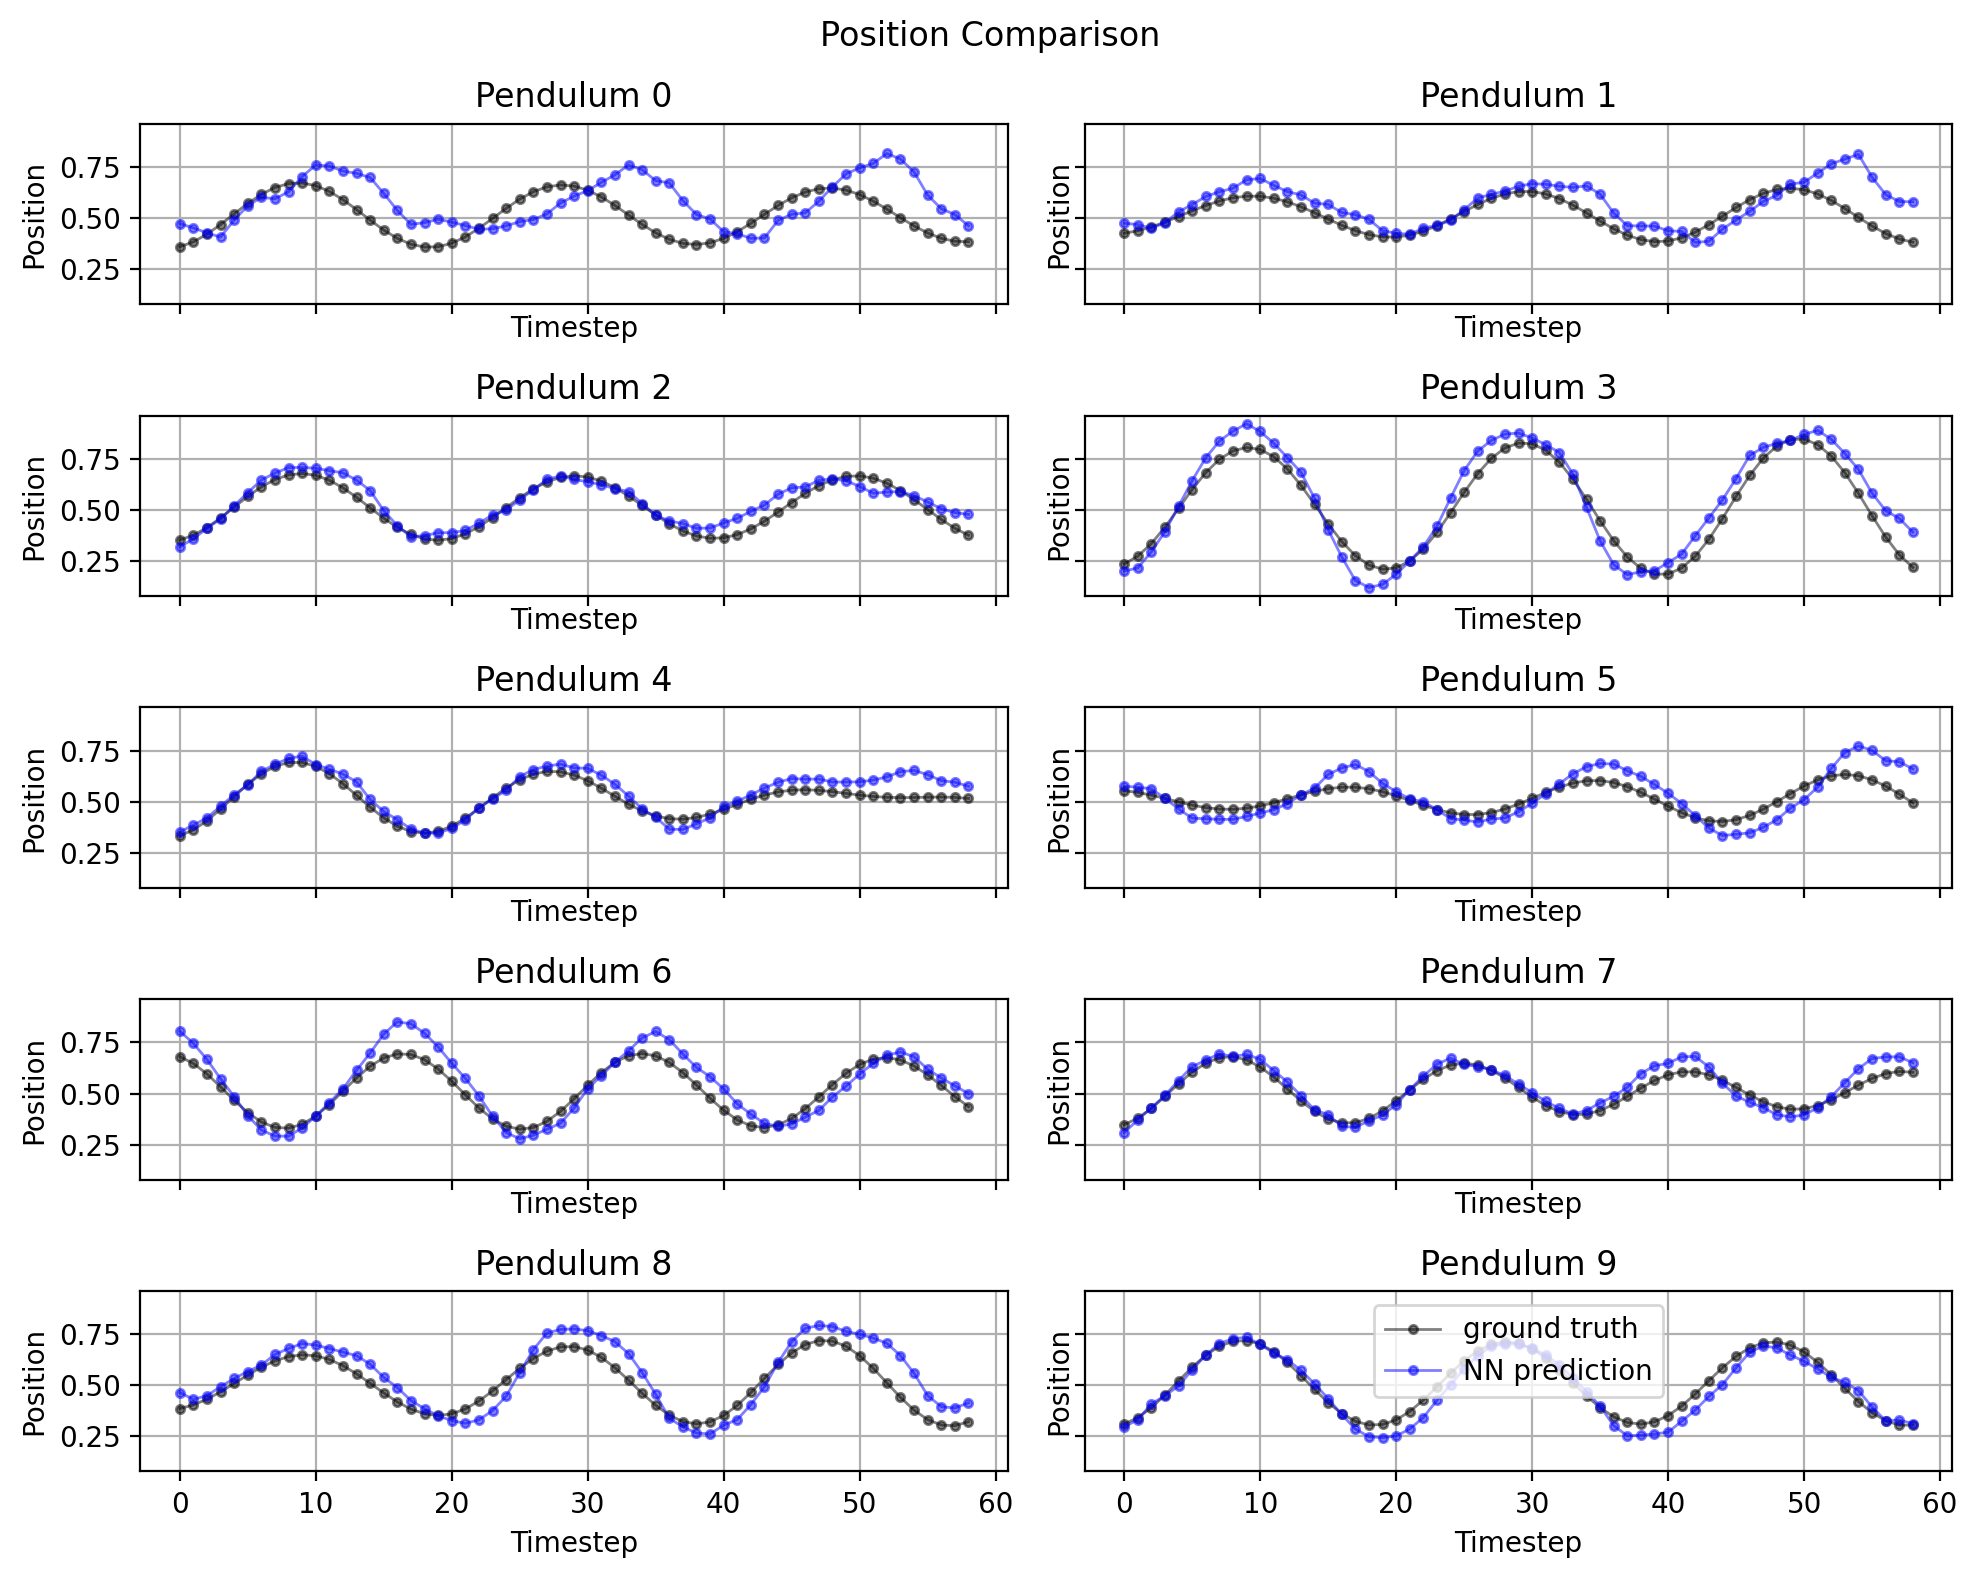

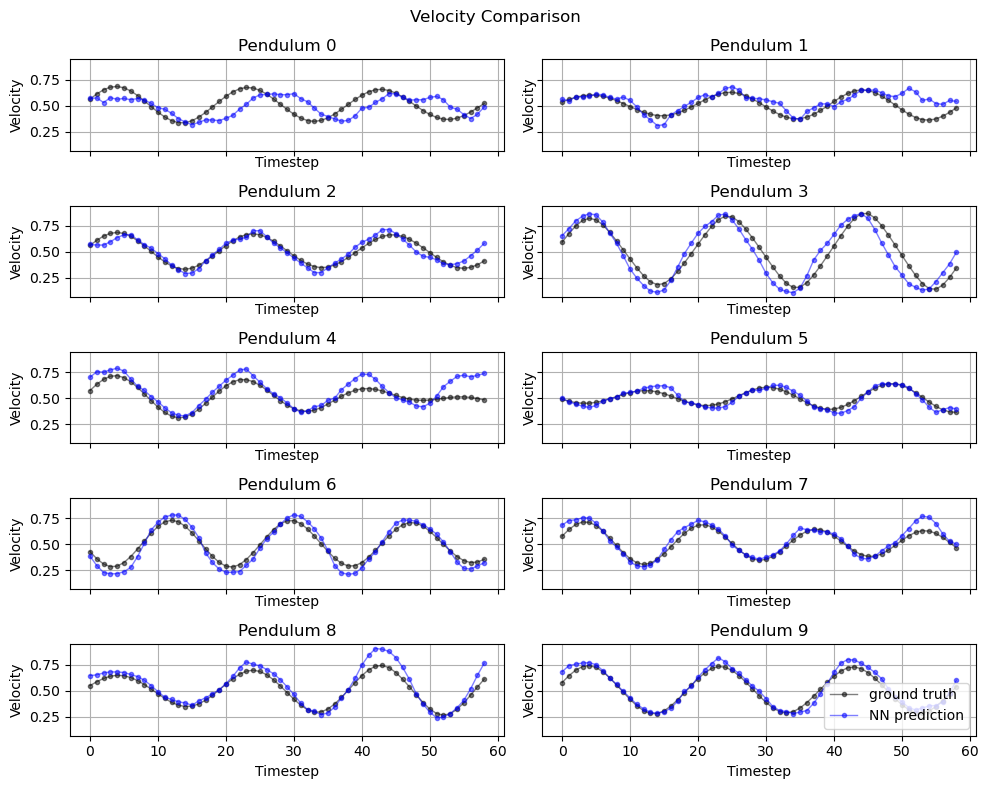

In [25]:
average_testing_loss, loss_list = inference_cheat()

print("average loss is: " + str(average_testing_loss))
visualize_test(loss_list, average_testing_loss, want_worst = False, want_avg = True)

average loss is: 0.028096573695097302


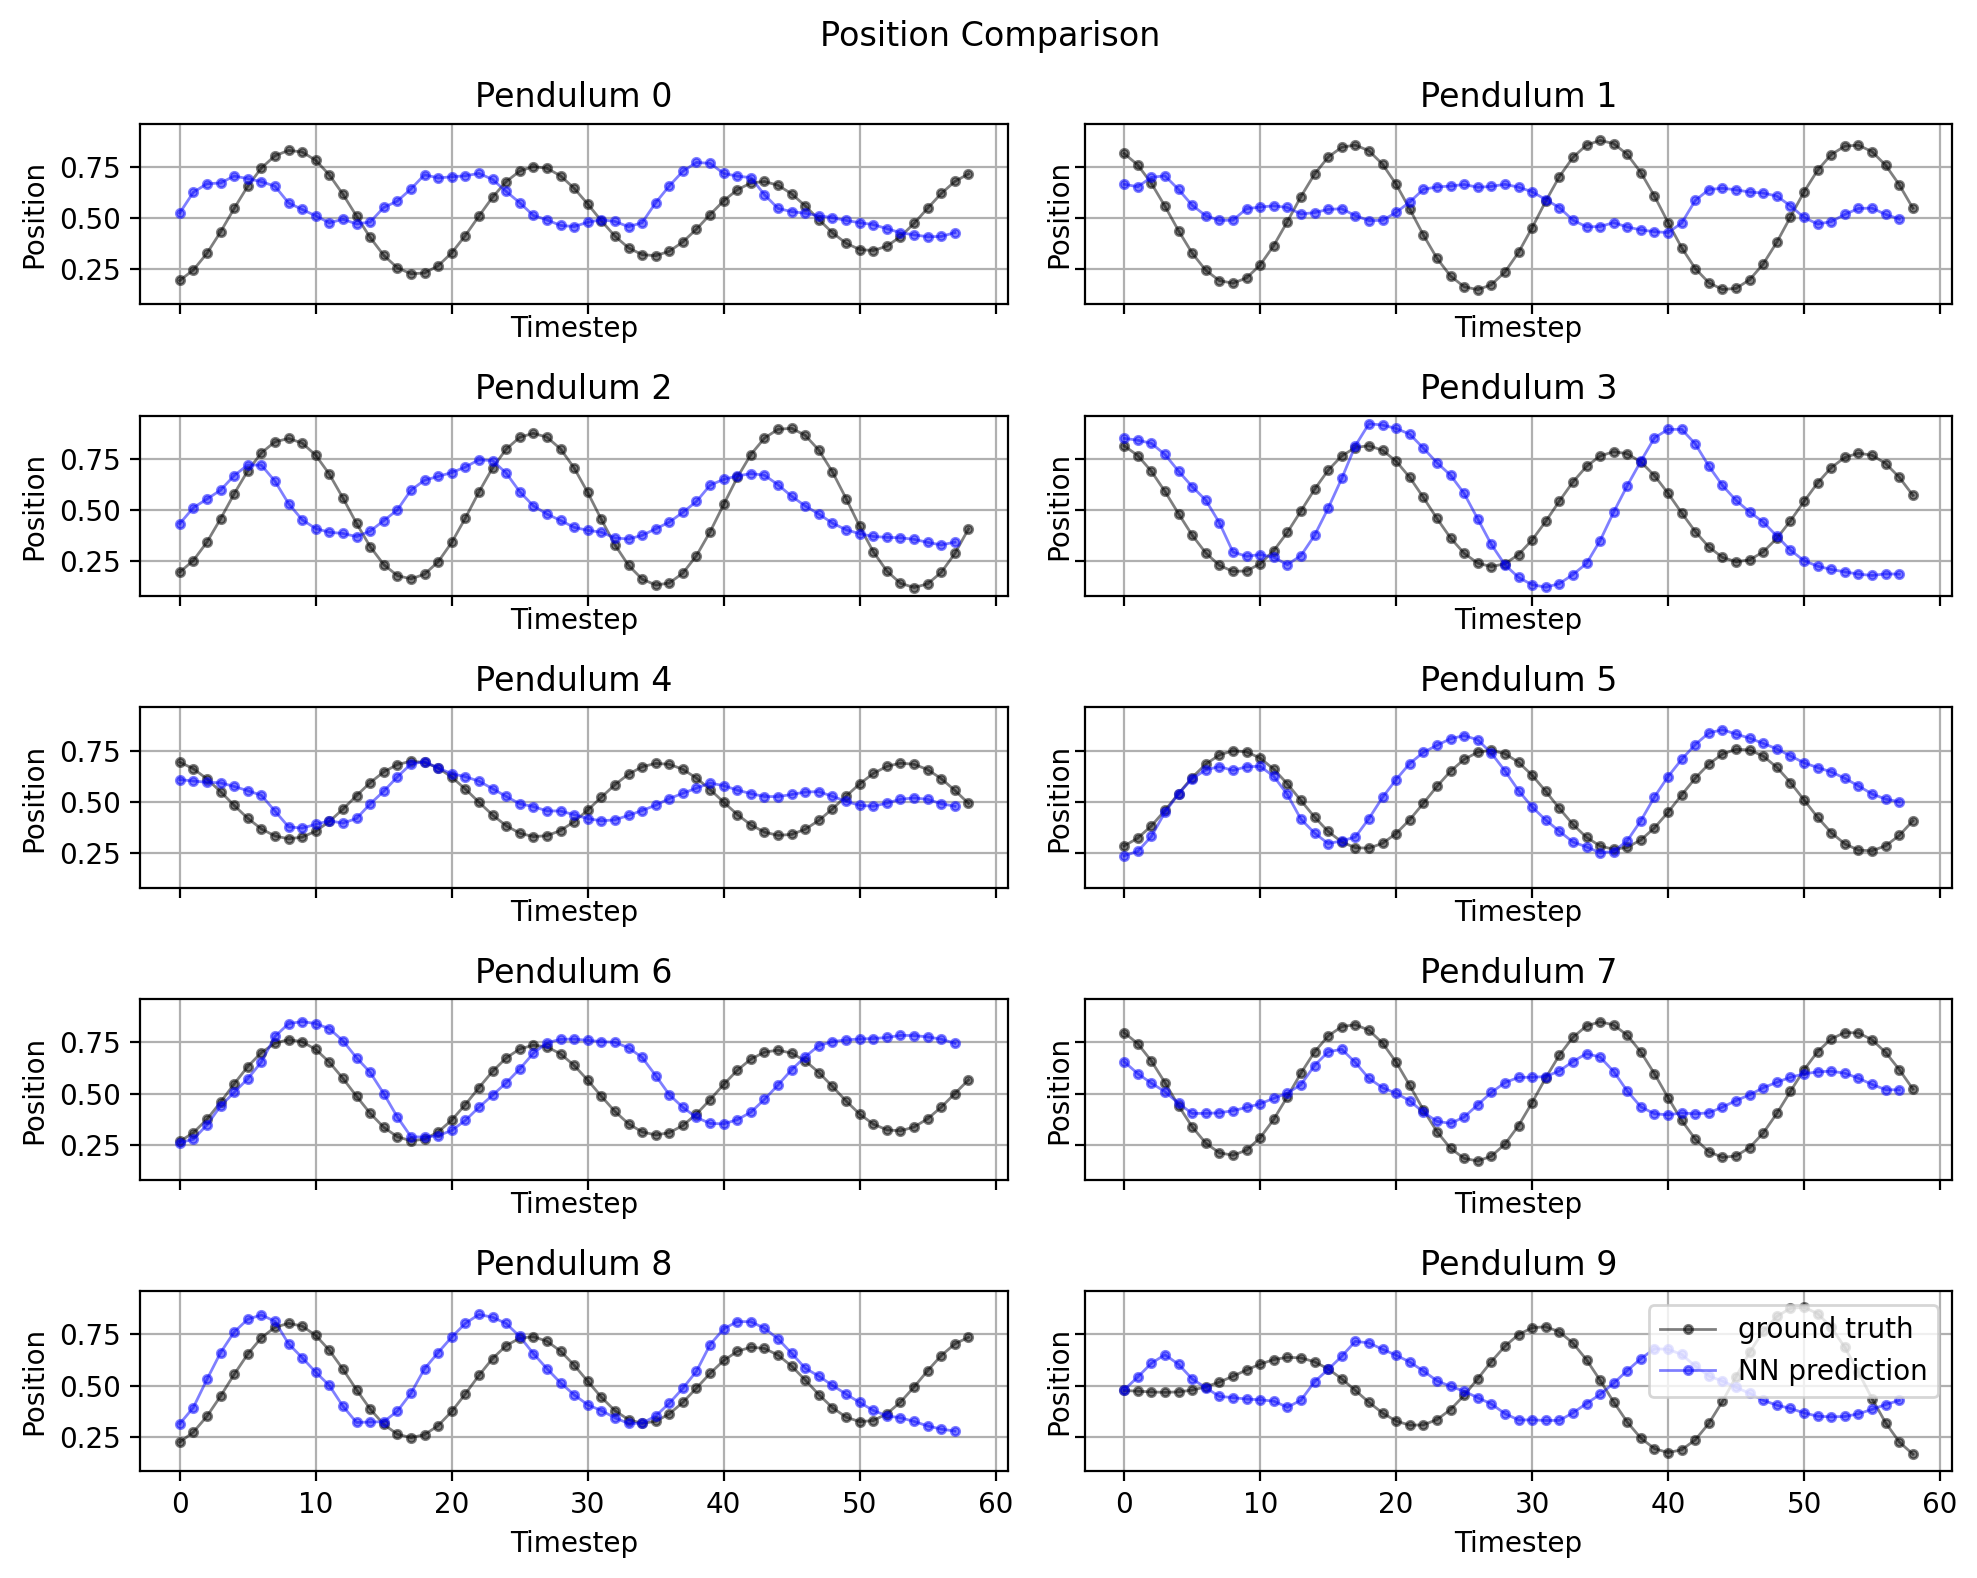

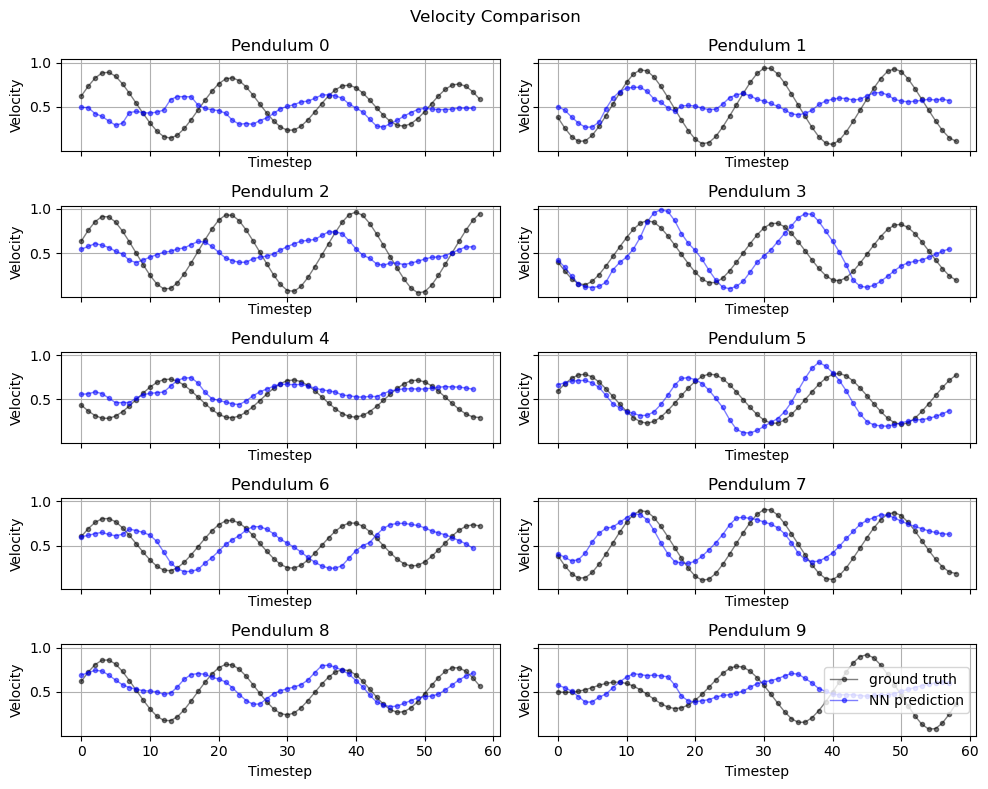

In [26]:
average_testing_loss, worst_dict = inference_one_input()
print("average loss is: {}".format(average_testing_loss))
visualize_worst_test(worst_dict)

### PE with Standardized data

In [21]:
mean_std_dict = preproceess_data_standardize(NUM_DATA = 1000, sanity_check = False)
best_model = train_transformer_teacher_forcing(EPOCH = 300)

Epoch: 0, Average training loss: 0.4691690802693157
Epoch: 30, Average training loss: 0.07473250695210523
Epoch: 60, Average training loss: 0.06640682679031824
Epoch: 90, Average training loss: 0.06228846895554417
Epoch: 120, Average training loss: 0.061660879785999975
Epoch: 150, Average training loss: 0.05966664838755737
Epoch: 180, Average training loss: 0.05848315401883489
Epoch: 210, Average training loss: 0.058246970104364366
Epoch: 240, Average training loss: 0.0573006068045091
Epoch: 270, Average training loss: 0.056790099996834036
Epoch: 300, Average training loss: 0.05594815720937623


average loss is: 0.15062417400896605
Visualizing test with loss: 0.14958551222182764


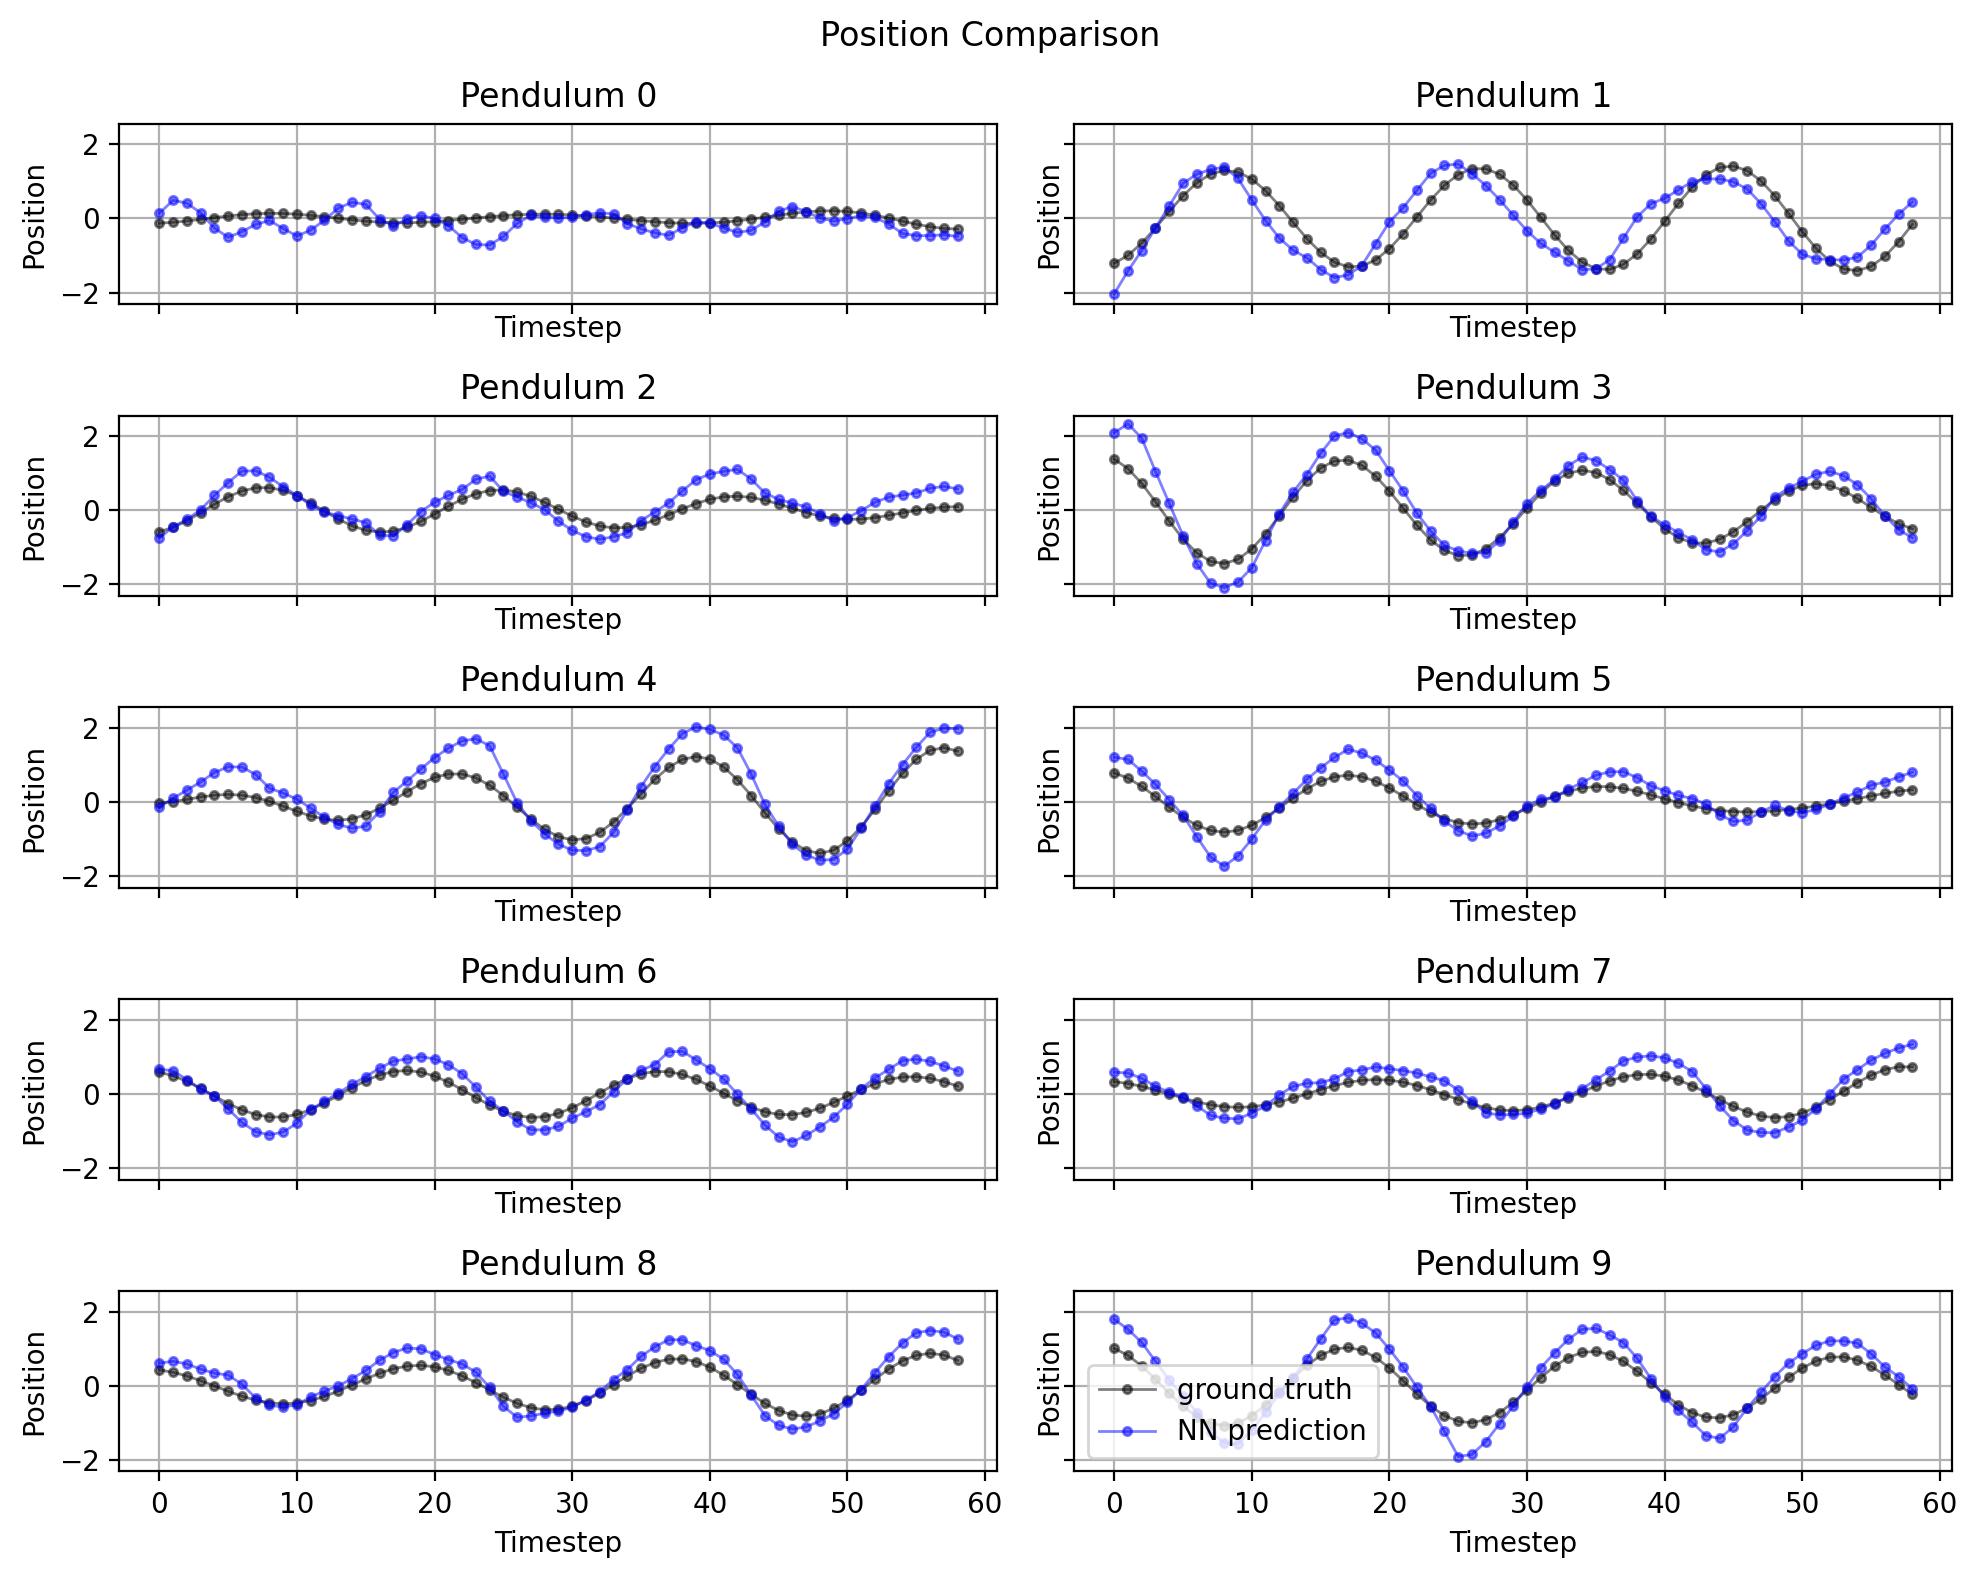

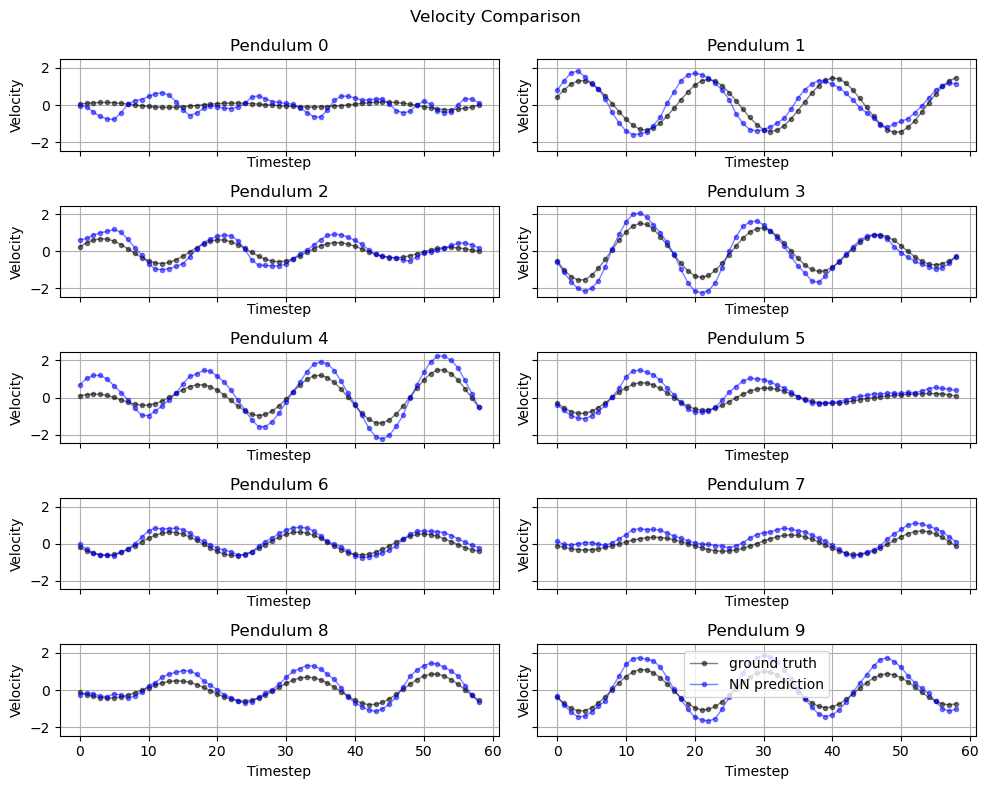

In [ ]:
average_testing_loss, loss_list = inference_cheat()
print("average loss is: " + str(average_testing_loss))
visualize_test(loss_list, average_testing_loss, want_worst = False, want_avg = True)

In [22]:
average_testing_loss, loss_array = inference_one_input()

Average testing loss is: 0.9646375059526154
Visualizing test with loss: 0.961609577983379


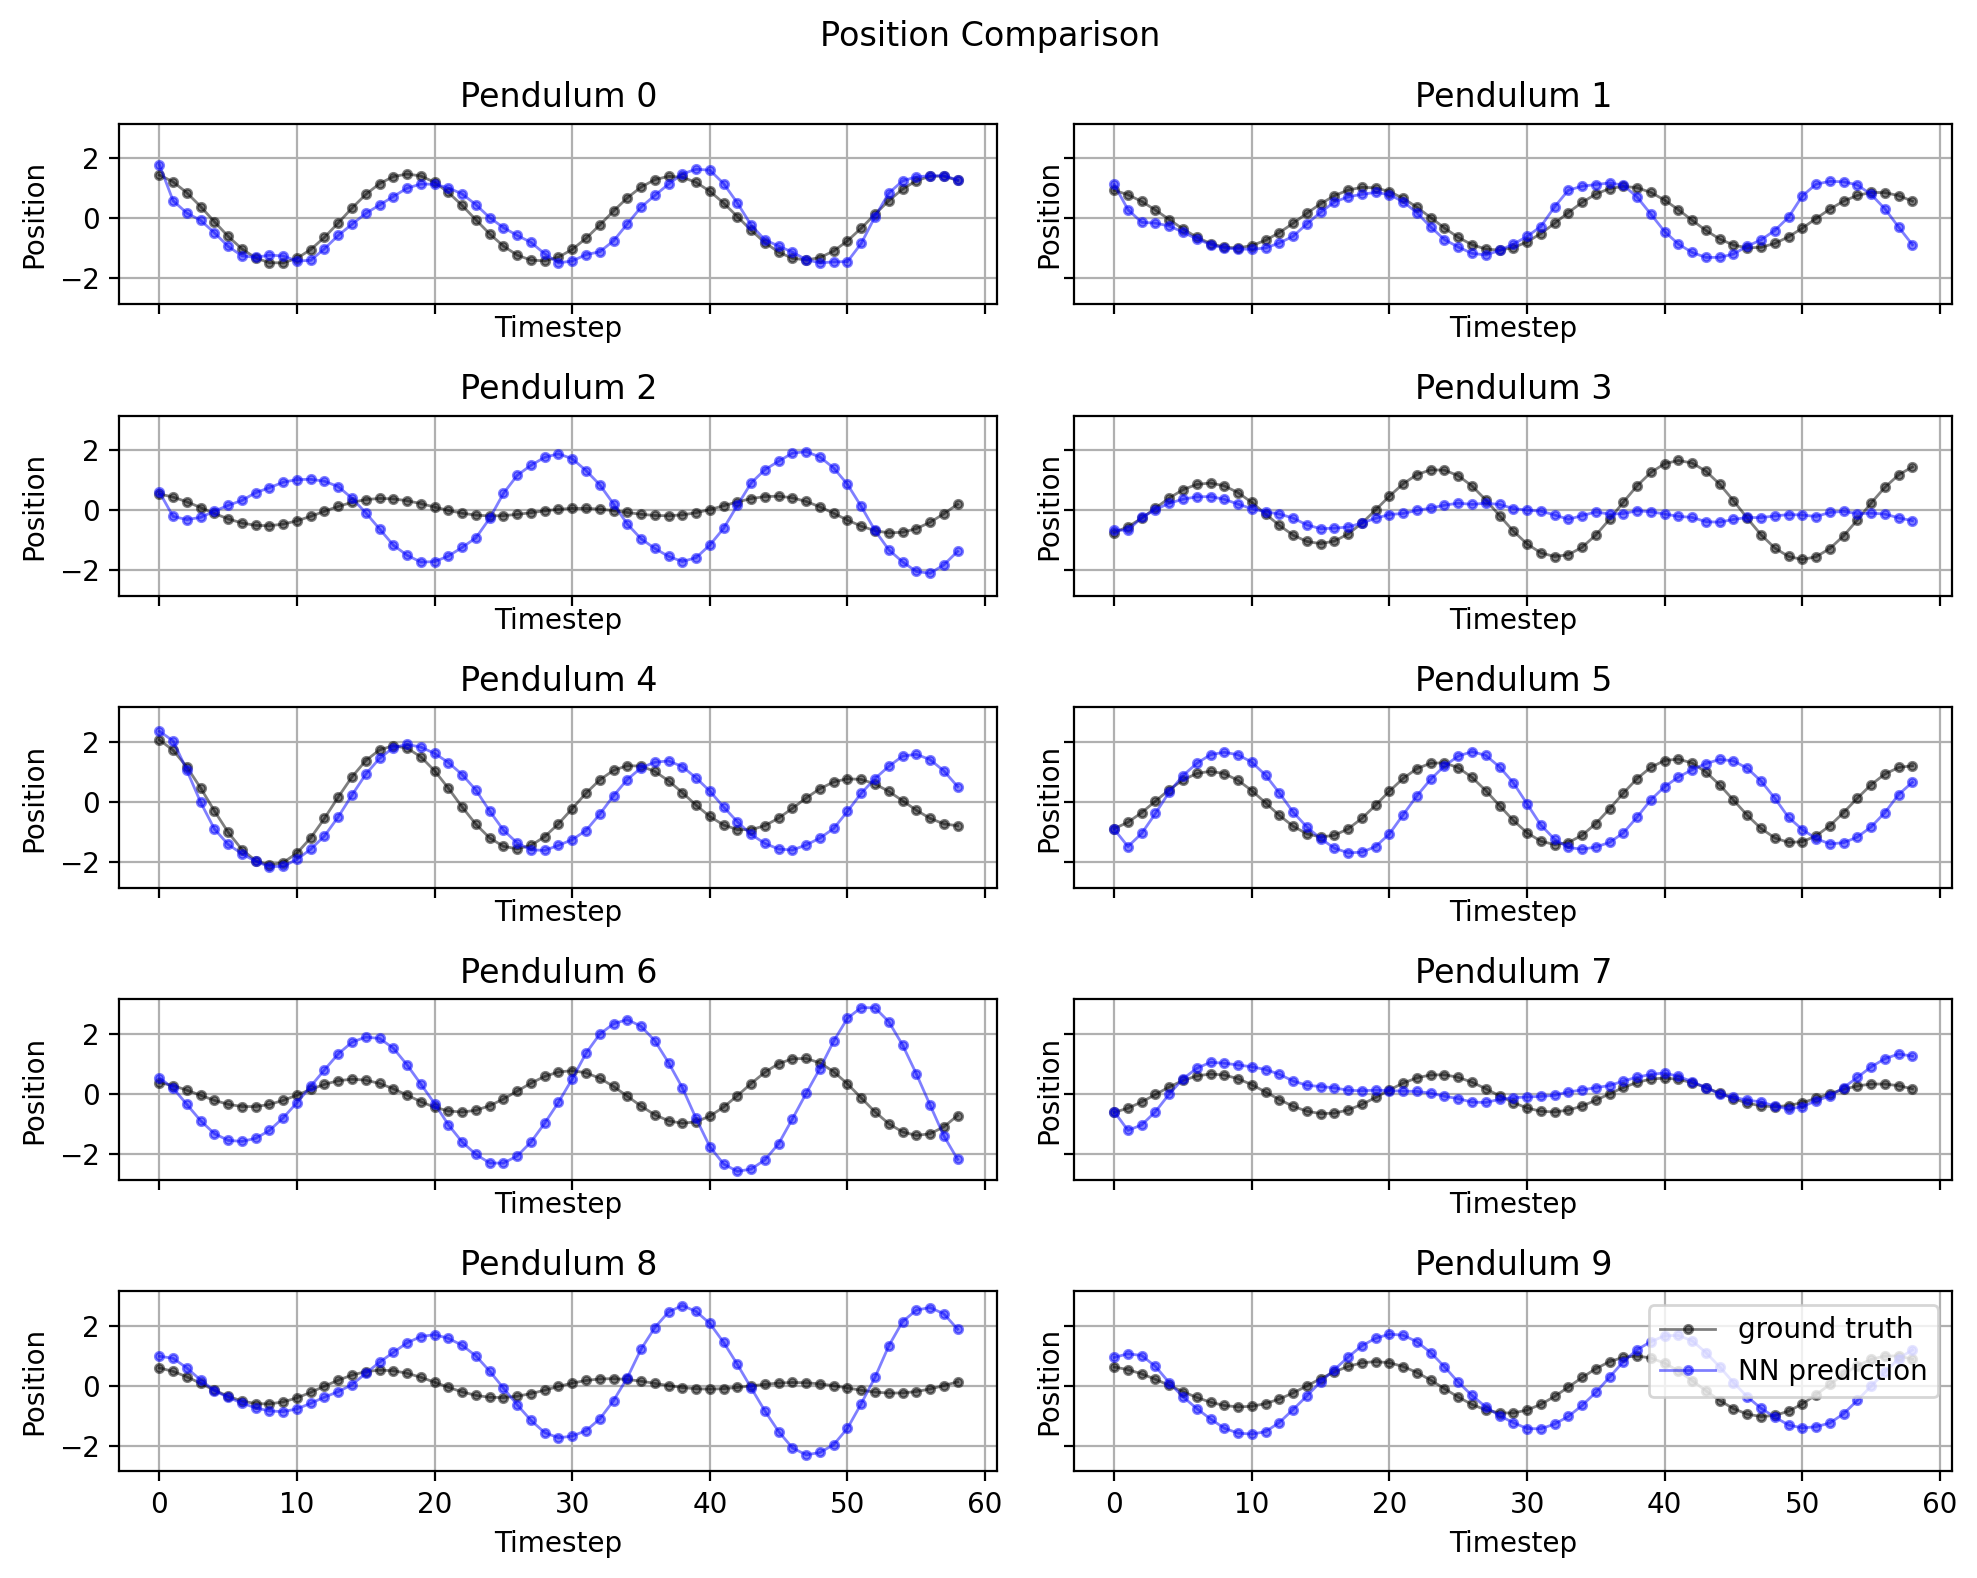

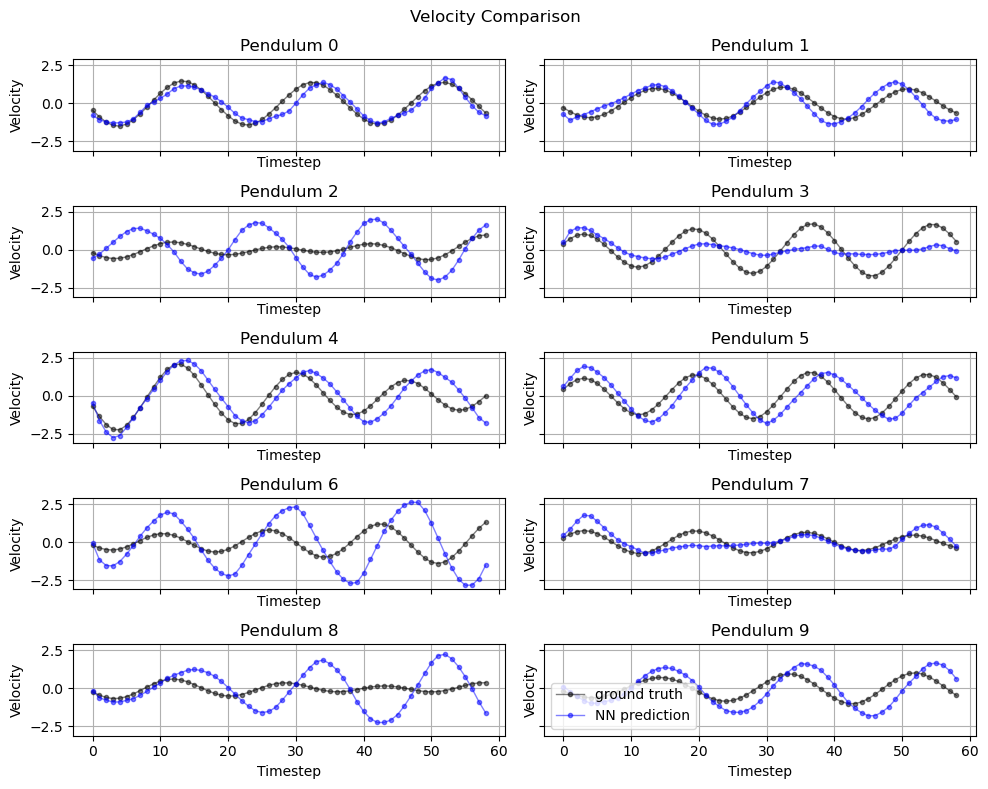

In [23]:
visualize_test(loss_array, average_testing_loss, want_worst = False, want_avg = True)

### Below is Sanity Check with og data

In [24]:
preproceess_data(NUM_DATA = 500, sanity_check = True)
best_model = train_transformer_teacher_forcing(EPOCH = 500)

Epoch: 0, Average training loss: 0.4728298369717907
Epoch: 50, Average training loss: 0.014443239710232685
Epoch: 100, Average training loss: 0.007613957991882847
Epoch: 150, Average training loss: 0.0060972758675155395
Epoch: 200, Average training loss: 0.006086234868262559
Epoch: 250, Average training loss: 0.004431575624283484
Epoch: 300, Average training loss: 0.004744888149469615
Epoch: 350, Average training loss: 0.004448134599368045
Epoch: 400, Average training loss: 0.004057316970807119
Epoch: 450, Average training loss: 0.004005758739915962
Epoch: 500, Average training loss: 0.003653701253221724


average loss is: 0.008845300194639536
Visualizing test with loss: 0.008839296060965658


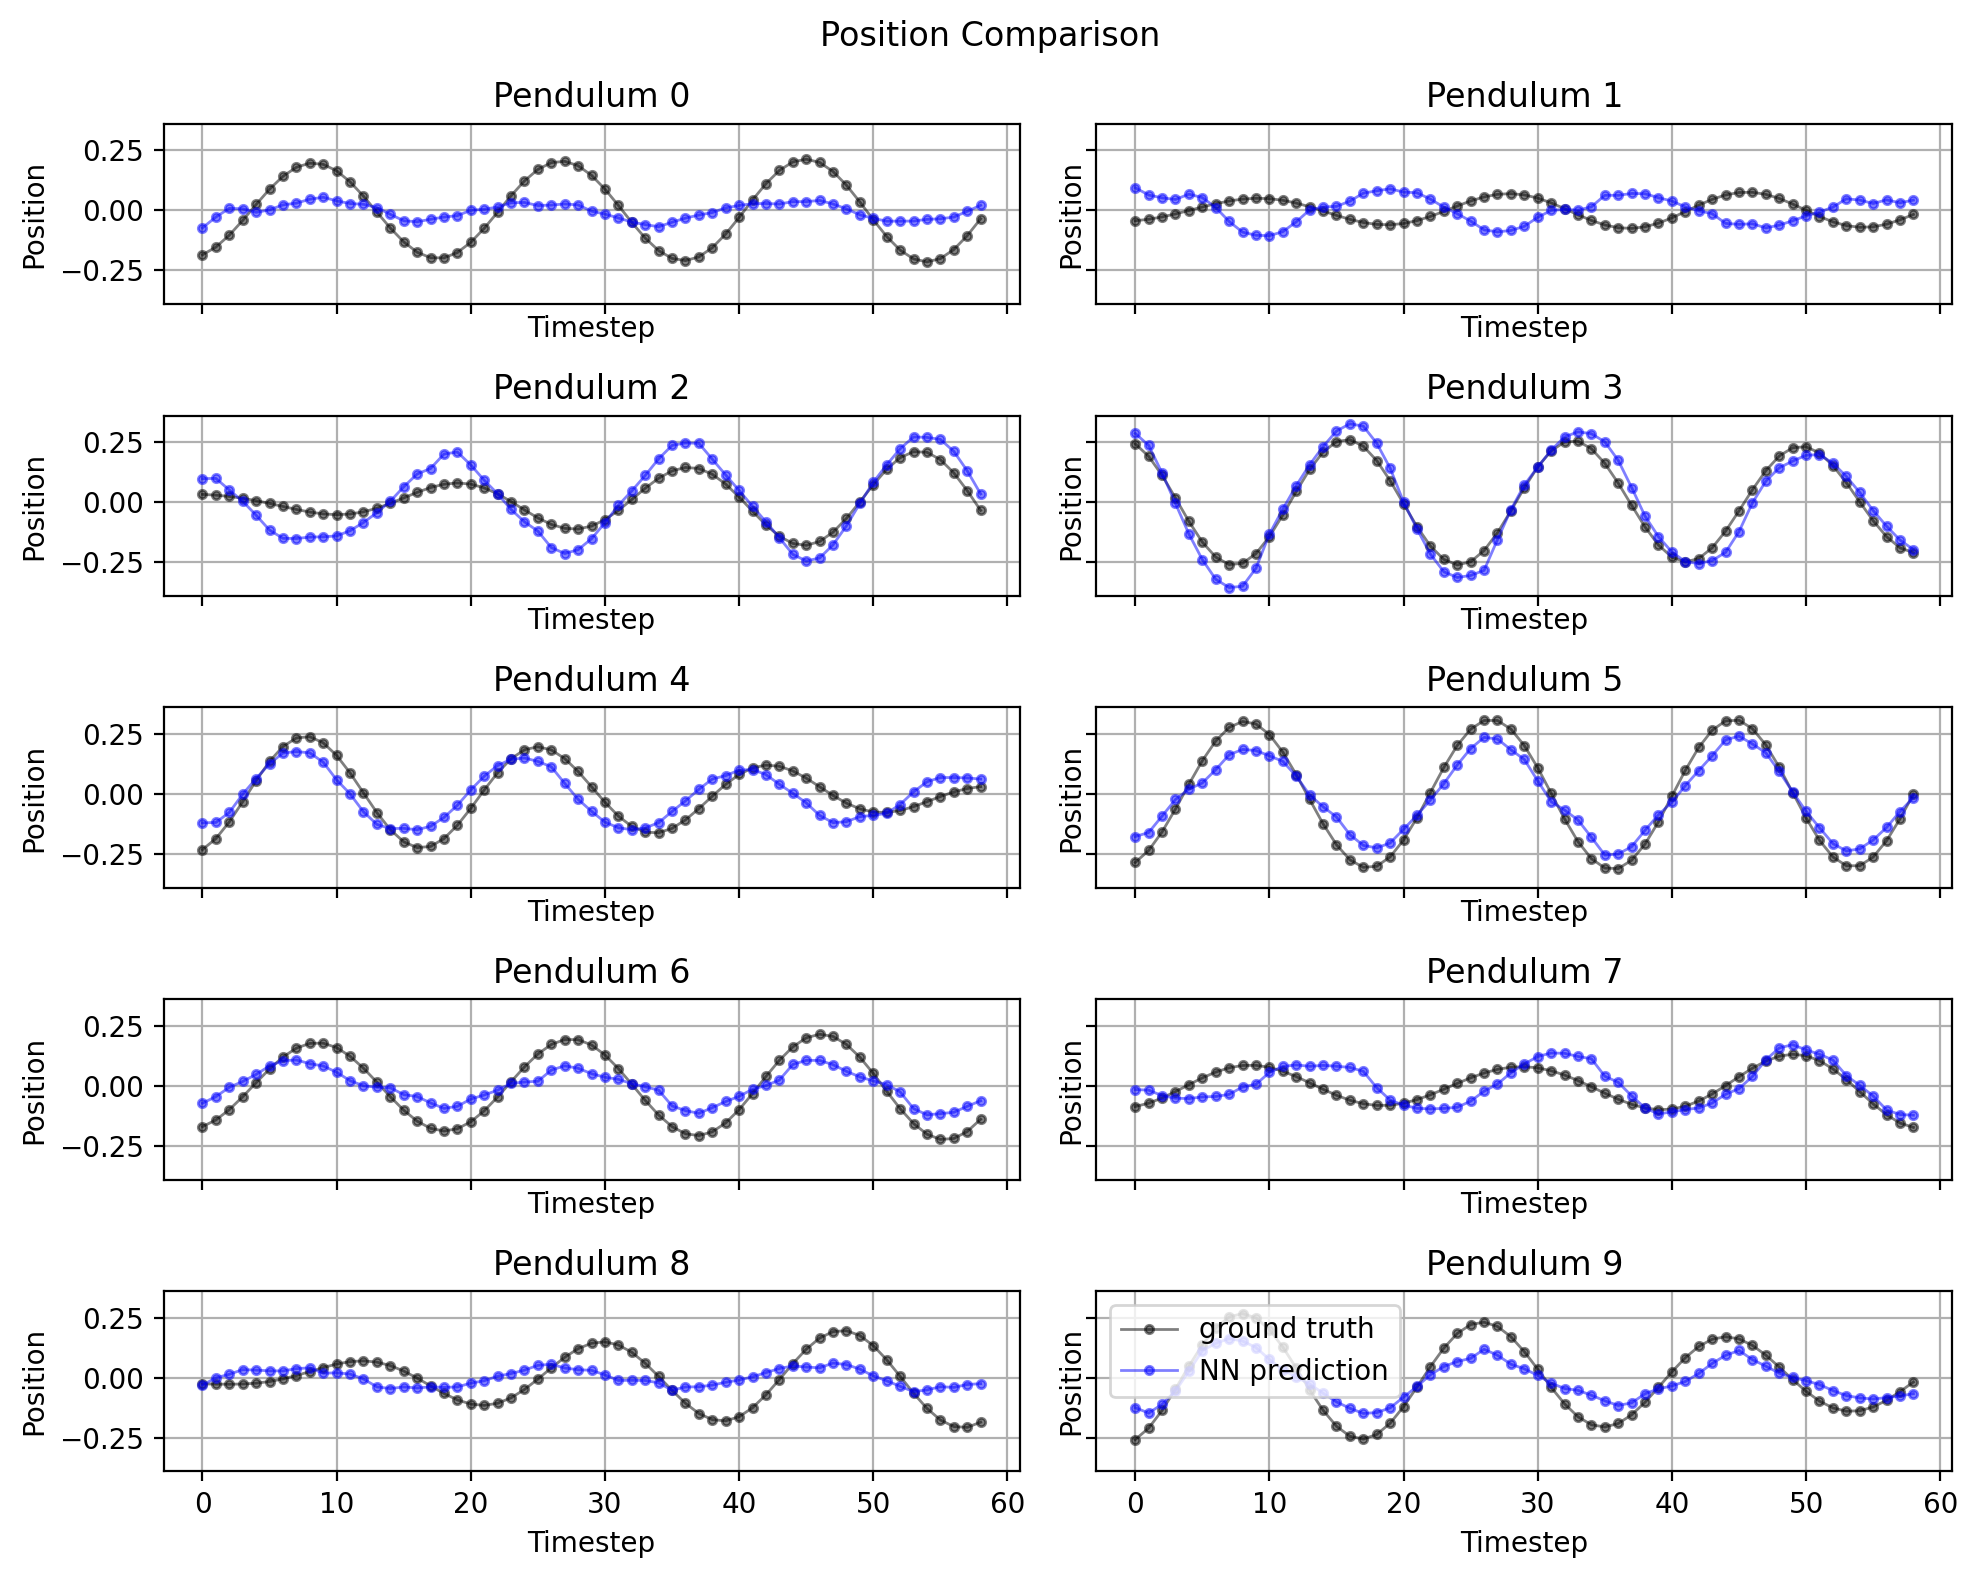

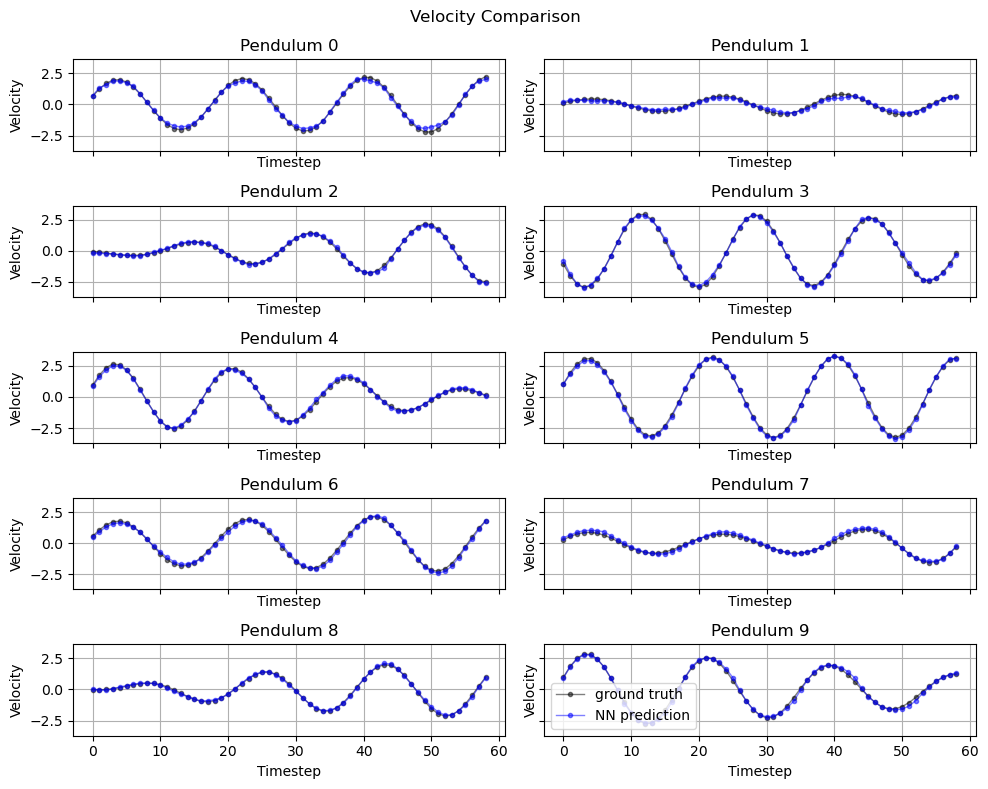

In [25]:
average_testing_loss, loss_list = inference_cheat()

print("average loss is: " + str(average_testing_loss))
visualize_test(loss_list, average_testing_loss, want_worst = False, want_avg = True)

1.4728303779363427
2.6874379263185117


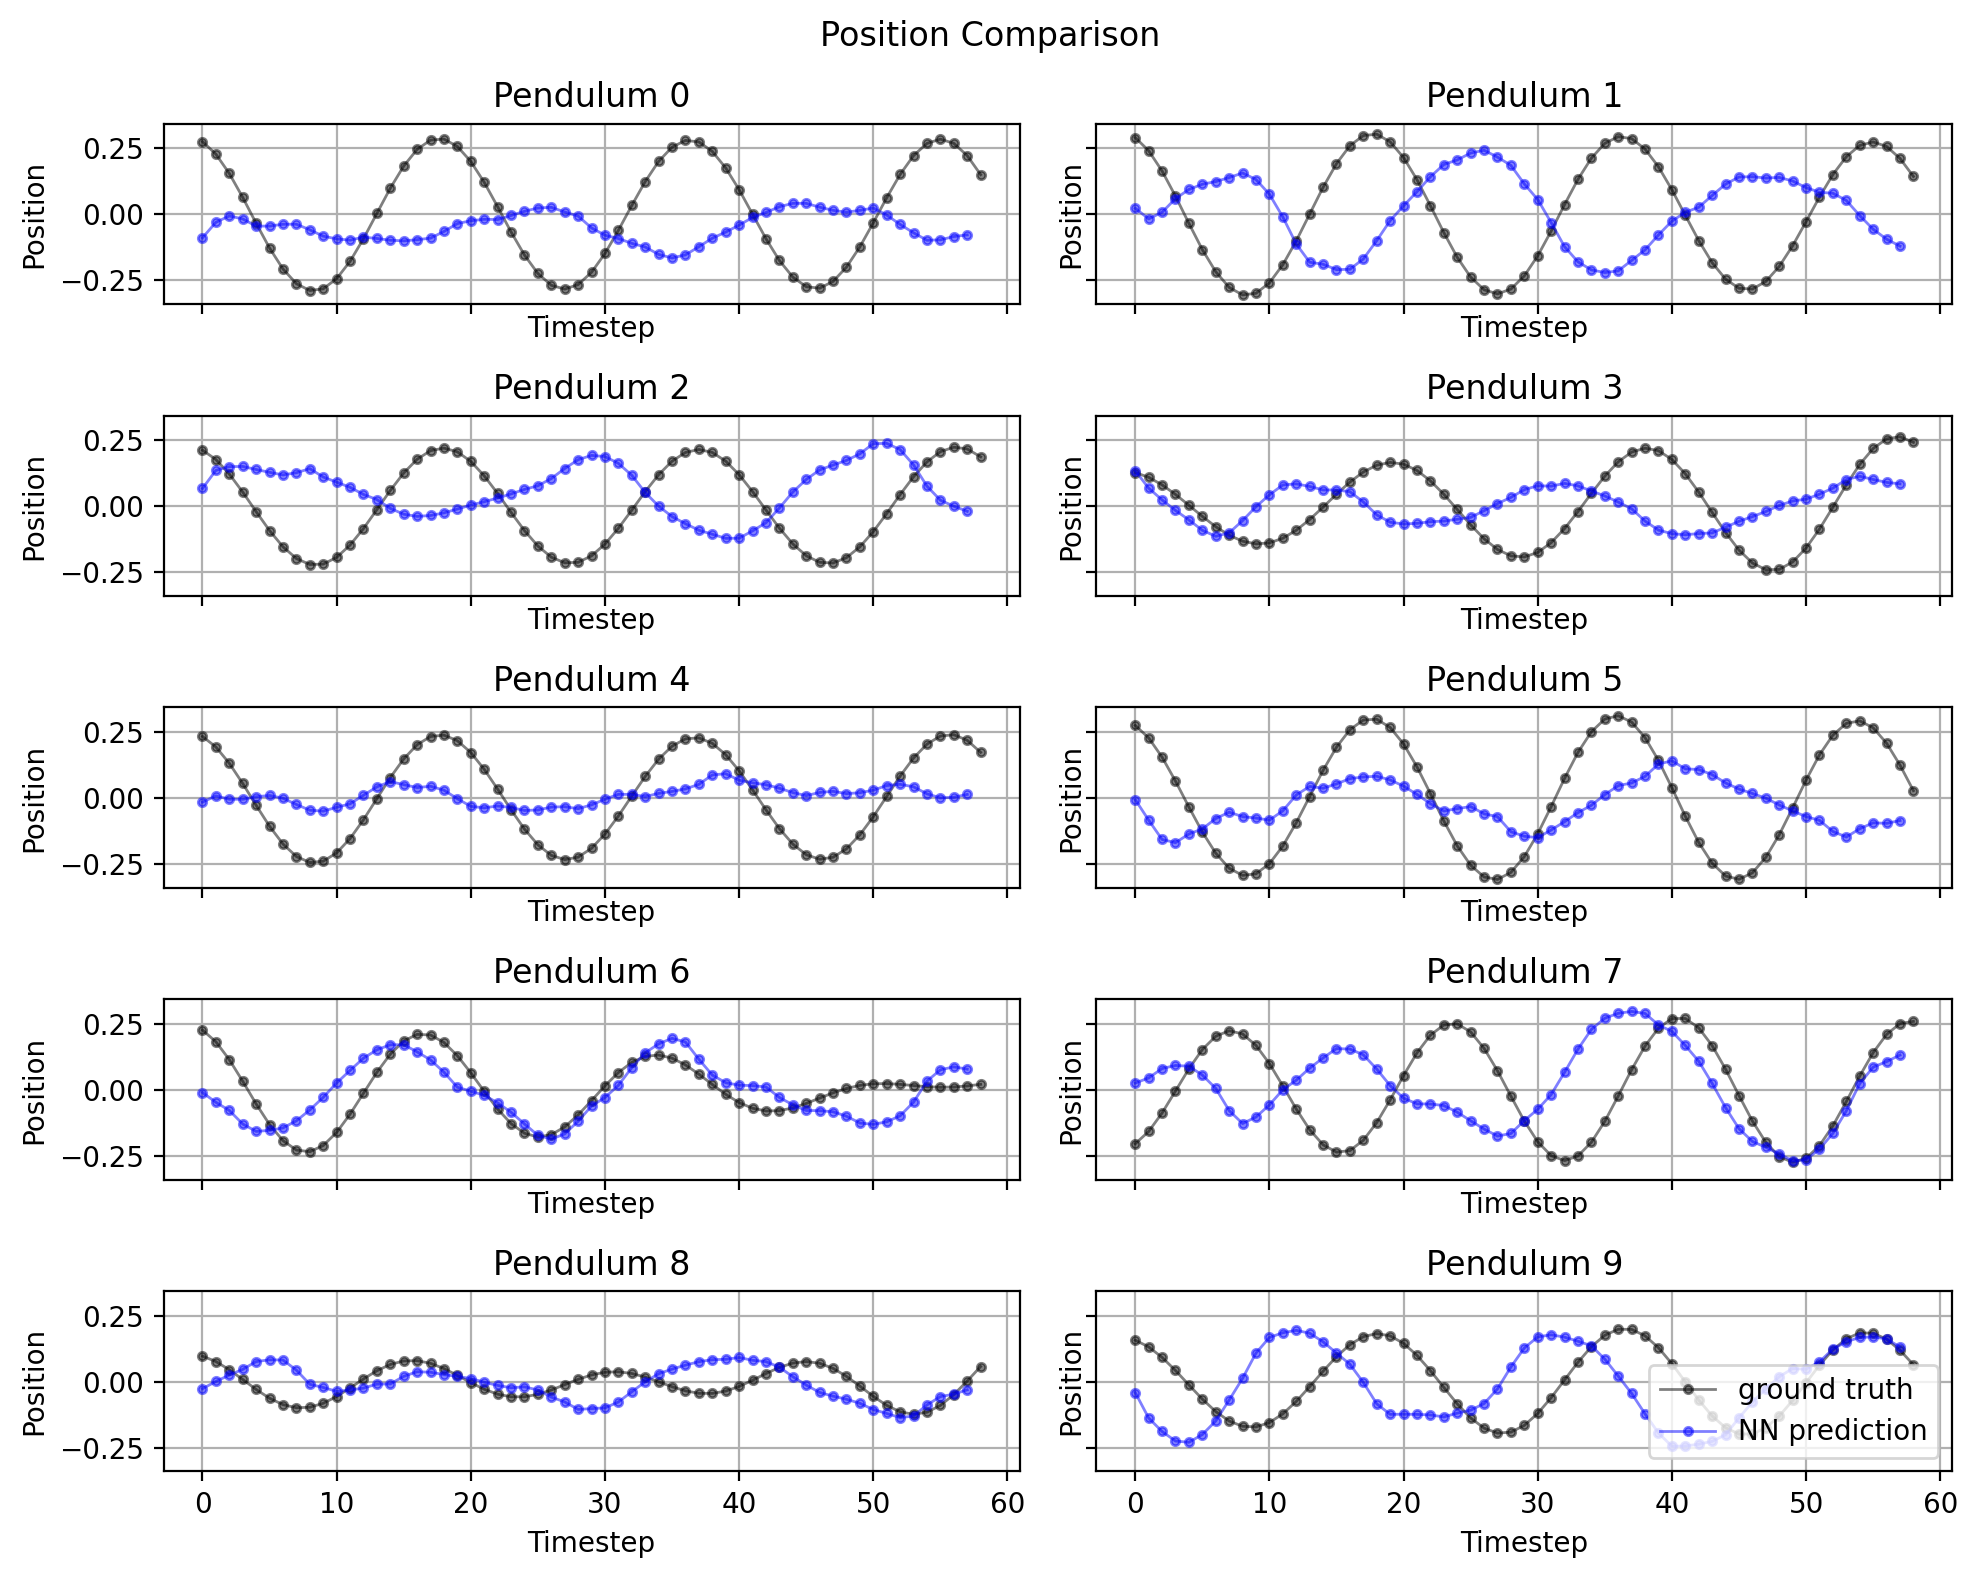

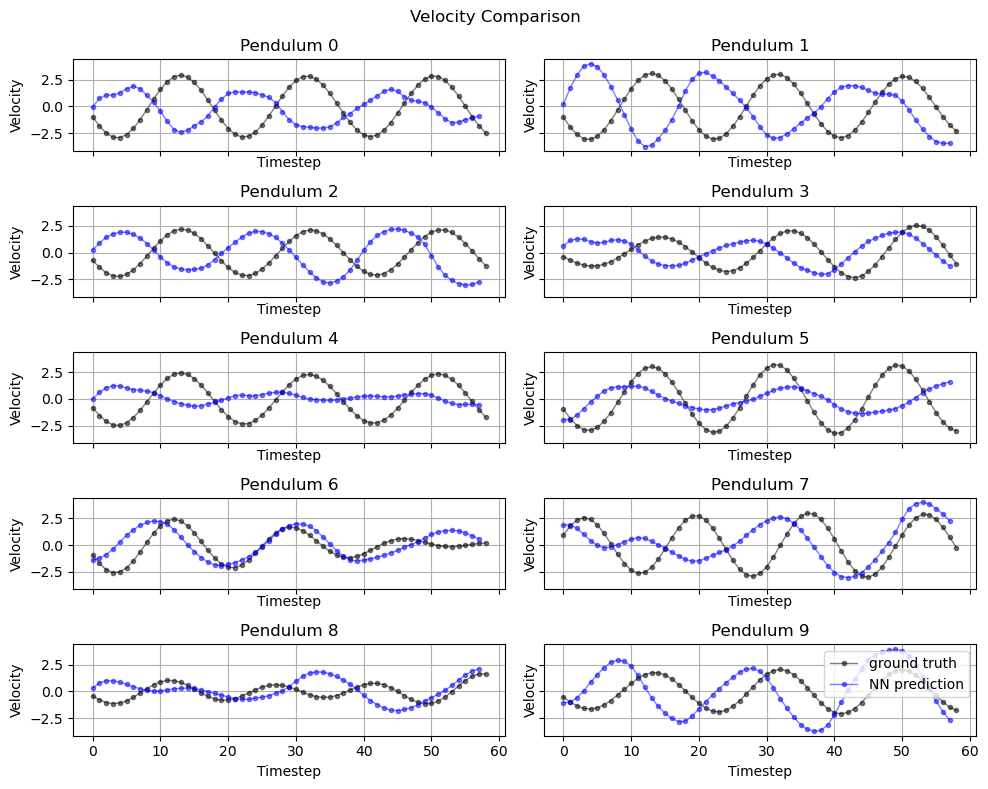

In [26]:
average_testing_loss, worst_dict = inference_one_input()
print(average_testing_loss)
print(worst_dict['loss'])
visualize_worst_test(worst_dict)